# P2 submission

**Team :** Laremontada61

General organization of this notebook:
- Handle size of the data
- EDA
- Data preprocessing
- Feasibility check of projects' methods
- Alternatives considered

**Project proposal** : Best breweries in the world 

The idea behind the identification of the best breweries is that the consumer might be more interested to try new and/or original products that come from a good brewery. This ranking is based on the ratings given by the tasters, but the ratings have to be weighted by the number of ratings for the best beers, the quality and emotions transmitted in the text following the different ratings. Some ratings might be biased or unclear so some of them might have to be filtered. Once the ranking is determined a visualisation is to be created to convey properly the attributes of the best breweries (number of “quality” beers, rankings by styles).

*Feedback*

Find and visualize the best breweries - clarity: 75 - creativity: 75 - feasibility: 75, using beer-level reviews as a proxy for brewery reviews is doable, yet will require detailed analysis. 

---

# Introduction

The BeerReviews dataset consists of beer reviews from two Beer rating websites: BeerAdvocate and RateBeer, for a period of 17 years ranging from 2001 to 2017.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import spacy
from IPython.display import display, Markdown, HTML

---

## Handle size of the data

### Load ratings.txt

We are processing data extracted from two similar beer rating websites: BeerAdvocate and RateBeer. The primary data structure is outlined in "ratings.txt," which includes user reviews providing information on beer (names, IDs, style, alcohol by volume), breweries, and users (date of review, user details, ratings, and comments on various aspects). Other supporting files include "beers.csv" (aggregated ratings for each beer), "Breweries" (information on breweries and their locations), and "Users" (user details on the number of ratings, reviews, and country of origin).

The most crucial file is "ratings.txt," as others are derived from its content. Due to its significant size (4.3 GB for BeerAdvocate and 3.95 GB for RateBeer), loading directly with a standard pipeline is impractical due to laptop memory limitations. To address this, we split the .txt files into N subfiles and load the data iteratively using a function.

The function allows control over the fraction of initial data loaded via the parameter N, which determines the number of subfiles to load. It also accommodates inherent differences between the two websites, such as additional review columns for BeerAdvocate.

Once loaded into DataFrames, we utilize the sample_data function to randomly sample a fraction of the data, enabling efficient handling of the substantial dataset.

In [2]:
def load_txt_file(website):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files 
        # NB : - need to be outside the repo folder !!
        #      - might need to change the path of the directory below
        directory = './../../dataset_BeerReviews/BeerAdvocate/ratings_split_BA/'
    else:
        directory = './../../dataset_BeerReviews/RateBeer/ratings_split_RB/'
    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(1, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns depending on the website
    if website == 'BeerAdvocate':
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text',
            'review'] # additional column compared to RB
    else:
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text']
    return final_df

def sample_data(df, ratio):
    # sample the data to make it even smaller
    return df.sample(frac = ratio, random_state=42)

In [3]:
# Load data
ratings_BA = load_txt_file('BeerAdvocate')
ratings_RB = load_txt_file('RateBeer')

In [4]:
# Sample data to make it even smaller AND RANDOMIZED (not randomized in the initial txt splitting process)
ratings_BA = sample_data(df = ratings_BA, ratio = 1)
ratings_RB = sample_data(df = ratings_RB, ratio = 1)

In [5]:
print(f"Length of ratings_BA (BeerAdvocate) dataframe : {len(ratings_BA)}")
print(f"Length of ratings_RB (RateBeer) dataframe : {len(ratings_RB)}")
display(ratings_BA.head(2),ratings_RB.head(2))

Length of ratings_BA (BeerAdvocate) dataframe : 444339
Length of ratings_RB (RateBeer) dataframe : 446795


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
43736,"Hello, My Name Is Ingrid",67199,BrewDog,16315,American Double / Imperial IPA,8.2,1370426400,aztraz,aztraz.671249,nan,nan,nan,nan,nan,3.50,nan,False
273843,Solstice D'été Aux Cerises,73716,Brasserie Dieu du Ciel!,1141,Berliner Weissbier,6.5,1444644000,hopsolutely,hopsolutely.513175,4.0,4.0,3.5,4.0,3.75,3.90,Enjoying with thanks to Phyl21ca.Rarely does a...,True


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
262500,Brew Brothers Prairie Berry Ale,21927,Brew Brothers Brewing &#40;Alberta&#41;,3033,Fruit Beer,5.5,1044615600,presario,5348,3,6,3,7,13,3.20,Big blue 1L bottle. Very loud pop announced t...
39881,Ed Hardy Premium Beer,110849,Cervecería Mexicana (Grupo Modelo),5973,Pale Lager,4.6,1281520800,Cajun,47922,2,4,2,3,5,1.60,Tasting - Gulf Brew 2010 - Pale amber white he...


### Load the other data

In [6]:
# BeerAdvocate
beers_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users.csv", header=1)

---

## EDA

Do univariate and multivariate analysis


- formats
- distributions
- missing values
- correlations
- etc...

**Organisation of the EDA**
- General data (users, breweries)
- Numerical ratings
- Textual reviews

### General data

**Formats**

In [7]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,object,object
brewery_name,object,object
brewery_id,object,object
style,object,object
abv,object,object
date,object,object
user_name,object,object
user_id,object,object
appearance,object,object


One can see that all the features of **ratings_BA** and **ratings_RB** have a `object` type, which is not very convenient if we want to automate the visualization process, for example plotting the distribution of the numerical features in histograms. As a first preprocessing step, we will thus convert the type of the numerical variables to `float64` with the function **convert_type** below.

In [8]:
def convert_type(df, col):
    df[col] = df[col].astype('float64')
    return df

# columns including the numerical features for both websites
# user_id is numerical in RB but categorical in BA so we don't include it
numerical_cols = ['beer_id', 'brewery_id', 'abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in numerical_cols : 
    ratings_BA = convert_type(ratings_BA, col)
    ratings_RB = convert_type(ratings_RB, col)

In [9]:
# Get types of features in each DataFrame
df_types = pd.concat([df.dtypes.rename(f"DataFrame {i+1}") for i, df in enumerate([ratings_BA, ratings_RB])], axis=1)
df_types

,DataFrame 1,DataFrame 2
beer_name,object,object
beer_id,float64,float64
brewery_name,object,object
brewery_id,float64,float64
style,object,object
abv,float64,float64
date,object,object
user_name,object,object
user_id,object,object
appearance,float64,float64


### Univariate analysis

**Descriptive statistics**

We can see the missing values per feature in each dataframe.

In [10]:
def get_feature_stats(df):
        """
        Obtains descriptive statistics for all features and percentage of missing values

        Parameters
        ----------
        df : DataFrame containing all data
        
        Returns
        -------
        stats : DataFrame containing the statistics for all features.
        """
        numerical = df.describe(include= ['float64', 'int64'])
        categorical = df.describe(include= ['object'])
        stats = pd.concat([numerical, categorical])
        
        # Select the desired statistics
        stats = stats.loc[['mean', 'std', '50%', 'unique', 'freq', 'max']]
        percentage = df.isnull().sum(axis = 0)*100 / len(df)
        stats.loc['missing_values'] = np.array(percentage)
        return stats

In [11]:
display(get_feature_stats(ratings_BA), get_feature_stats(ratings_RB))

,beer_id,brewery_id,abv,appearance,aroma,palate,taste,overall,rating,beer_name,brewery_name,style,date,user_name,user_id,text,review
mean,49930.822187,7393.904217,6.283523,3.763298,3.662354,3.670929,3.713133,3.724937,3.676796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,64384.554923,10963.761690,2.314747,0.620217,0.684314,0.672210,0.703822,0.681856,0.690097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,21163.000000,853.000000,5.400000,4.000000,3.750000,3.750000,3.750000,4.000000,3.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22878,1947,104,5809,39863,39863,196394,2
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10046,37472,31061,628,3833,3833,247685,254214
max,293278.000000,49808.000000,67.500000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
missing_values,0.000225,0.000450,0.000450,0.000450,0.000450,0.783636,0.000450,0.000450,0.000450,36.780926,36.780926,36.780926,36.780926,36.780926,0.00045,0.00045,0.00045


,beer_id,brewery_id,abv,appearance,aroma,palate,taste,overall,rating,beer_name,brewery_name,style,date,user_name,user_id,text
mean,143633.215959,6031.760075,6.134699,3.271936,6.057893,3.071982,6.139671,12.431072,3.097255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,145026.596254,7227.842634,1.851008,0.835354,1.759857,0.851453,1.730788,3.602640,0.793646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,95677.000000,2244.000000,5.500000,3.000000,6.000000,3.000000,6.000000,13.000000,3.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30957,1940,89,6089,16554,16551,445825
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3650,28394,62348,298,5320,5320,71
max,536439.000000,32240.000000,30.000000,5.000000,10.000000,5.000000,10.000000,20.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
missing_values,0.000224,0.000224,0.000224,0.000224,0.000224,2.530243,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448,0.000448


In [12]:
df1 = get_feature_stats(breweries_BA)
df2 = get_feature_stats(breweries_RB)
df3 = get_feature_stats(users_BA)
df4 = get_feature_stats(users_RB)

# Using HTML/CSS to display DataFrames in the same row
html = f'<div style="display: flex; flex-direction: row;"> \
            <div style="text-align: center; margin-right: 20px;"> \
                <h3>Breweries BeerAdvocate</h3>{df1.to_html()} \
            </div> \
            <div style="text-align: center; margin-right: 100px;"> \
                <h3>Breweries RateBeer</h3>{df2.to_html()} \
            </div> \
            <div style="text-align: center; margin-right: 20px;"> \
                <h3>Users BeerAdovate</h3>{df3.to_html()} \
            </div> \
            <div style="text-align: center;"> \
                <h3>Users RateBeer</h3>{df4.to_html()} \
            </div> \
        </div>'

display(HTML(html))

,id,nbr_beers,location,name
mean,25954.841270,21.056331,NaN,NaN
std,16219.989105,69.417841,NaN,NaN
50%,29178.000000,6.000000,NaN,NaN
unique,NaN,NaN,297,16237
freq,NaN,NaN,1431,34
max,49817.000000,1196.000000,NaN,NaN
missing_values,0.000000,0.000000,0.0,0.0
,id,nbr_beers,location,name
mean,16639.680061,19.022655,NaN,NaN
std,9408.751678,31.542620,NaN,NaN


**Graphical descriptions**

- **Users**

In [13]:
display(users_BA.head(2), users_RB.head(2))

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"


,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain


In [14]:
print(f"Number of unique users (based on user_id) in BeerAdvocate: {len(users_BA['user_id'].unique())}")
print(f"Number of unique users (based on user_id) in RateBeer: {len(users_RB['user_id'].unique())}")

print(f"\nNumber of unique users (based on user_name) in BeerAdvocate: {len(users_BA['user_name'].unique())}")
print(f"Number of unique users (based on user_name) in RateBeer: {len(users_RB['user_name'].unique())}")

print(f"\nDifference in number of unique users in BeerAdvocate between id and name: {len(users_BA['user_id'].unique()) - len(users_BA['user_name'].unique())}")
print(f"Difference in number of unique users in RateBeer between id and name: {len(users_RB['user_id'].unique()) - len(users_RB['user_name'].unique())}")

print(f"\nNumber of unique location for the users in BeerAdvocate: {len(users_BA['location'].unique())}")
print(f"Number of unique location for the users in RateBeer: {len(users_RB['location'].unique())}")

Number of unique users (based on user_id) in BeerAdvocate: 153704
Number of unique users (based on user_id) in RateBeer: 70120

Number of unique users (based on user_name) in BeerAdvocate: 153704
Number of unique users (based on user_name) in RateBeer: 70174

Difference in number of unique users in BeerAdvocate between id and name: 0
Difference in number of unique users in RateBeer between id and name: -54

Number of unique location for the users in BeerAdvocate: 195
Number of unique location for the users in RateBeer: 223


ADD explanation of why we have a difference

- **Breweries**

In [15]:
display(breweries_BA.head(2), breweries_RB.head(2))

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1


,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13


In [16]:
# todo
print(f"Number of unique breweries (based on id) in BeerAdvocate: {len(breweries_BA['id'].unique())}")
print(f"Number of unique breweries (based on id) in RateBeer: {len(breweries_RB['id'].unique())}")

print(f"\nNumber of unique breweries (based on name) in BeerAdvocate: {len(breweries_BA['name'].unique())}")
print(f"Number of unique breweries (based on name) in RateBeer: {len(breweries_RB['name'].unique())}")

print(f"\nDifference in number of unique breweries in BeerAdvocate between id and name: {len(breweries_BA['id'].unique()) - len(breweries_BA['name'].unique())}")
print(f"Difference in number of unique breweries in RateBeer between id and name: {len(breweries_RB['id'].unique()) - len(breweries_RB['name'].unique())}")

print(f"\nNumber of unique location for the breweries in BeerAdvocate: {len(breweries_BA['location'].unique())}")
print(f"Number of unique location for the breweries in RateBeer: {len(breweries_RB['location'].unique())}")

Number of unique breweries (based on id) in BeerAdvocate: 16758
Number of unique breweries (based on id) in RateBeer: 24189

Number of unique breweries (based on name) in BeerAdvocate: 16237
Number of unique breweries (based on name) in RateBeer: 24173

Difference in number of unique breweries in BeerAdvocate between id and name: 521
Difference in number of unique breweries in RateBeer between id and name: 16

Number of unique location for the breweries in BeerAdvocate: 297
Number of unique location for the breweries in RateBeer: 267


ADD explanation of why we have a difference

In [17]:
# Plot the entire distribution of locations
#breweries_BA_plot = breweries_BA.sample(frac = 0.1)
#breweries_RB_plot = breweries_RB.sample(frac = 0.1)
#
#fig, axs = plt.subplots(1,2,figsize=(10, 40))
#sns.countplot(y='location', data=breweries_BA_plot, order = breweries_BA_plot['name'].value_counts().index, palette=sns.color_palette("colorblind"), ax = axs[0])
#sns.countplot(y='location', data=breweries_RB_plot, order = breweries_RB_plot['name'].value_counts().index, palette=sns.color_palette("colorblind"), ax = axs[1])
#axs[0].title('Distribution of Locations in BeerAdvocate')
#axs[1].title('Distribution of Locations in RateBeer')
#axs[0].set_xlabel('Number of beers')
#axs[1].set_ylabel('Location')
##plt.xticks(rotation=45) 
#plt.tight_layout()
#plt.show()

C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1877526469.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_breweries_location_RB.index, y=top_10_breweries_location_RB.values, alpha=0.8, palette=sns.color_palette("colorblind"))


C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1877526469.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_breweries_location_BA.index, y=top_10_breweries_location_BA.values, alpha=0.8, palette=sns.color_palette("colorblind"))


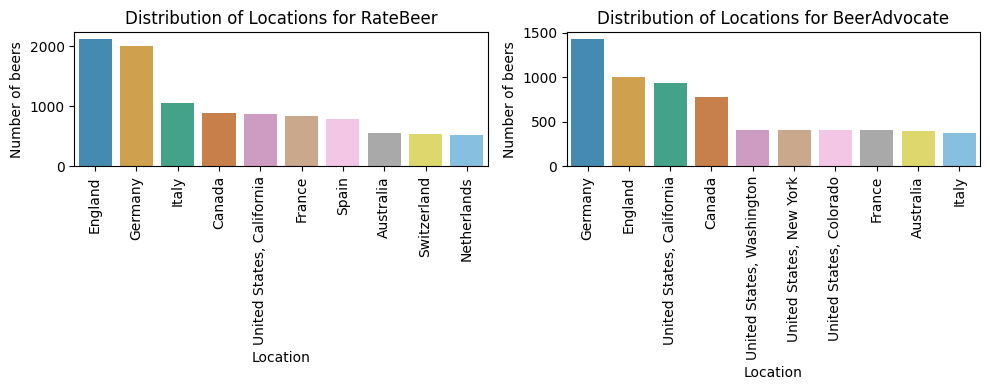

In [18]:
# Count the number of beers for each location
def count_Top_10(breweries_df):
    number_of_beer_per_country = breweries_df['location'].value_counts()
    top_10_breweries_location = number_of_beer_per_country.nlargest(10)
    return top_10_breweries_location, number_of_beer_per_country

top_10_breweries_location_RB, _ = count_Top_10(breweries_RB)
top_10_breweries_location_BA, _ = count_Top_10(breweries_BA)

_ , number_of_beer_per_country_RB = count_Top_10(breweries_RB)
_ , number_of_beer_per_country_BA = count_Top_10(breweries_BA)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=top_10_breweries_location_RB.index, y=top_10_breweries_location_RB.values, alpha=0.8, palette=sns.color_palette("colorblind"))
plt.title('Distribution of Locations for RateBeer')
plt.ylabel('Number of beers')
plt.xlabel('Location')
plt.xticks(rotation=90) 

plt.subplot(1, 2, 2)
sns.barplot(x=top_10_breweries_location_BA.index, y=top_10_breweries_location_BA.values, alpha=0.8, palette=sns.color_palette("colorblind"))
plt.title('Distribution of Locations for BeerAdvocate')
plt.ylabel('Number of beers')
plt.xlabel('Location')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

C:\Users\julie\AppData\Local\Temp\ipykernel_15892\415798225.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=us_filtered_RB.index, y=us_filtered_RB.values, alpha=0.8, palette=sns.color_palette("colorblind"))
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\415798225.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=us_filtered_BA.index, y=us_filtered_BA.values, alpha=0.8, palette=sns.color_palette("colorblind"))


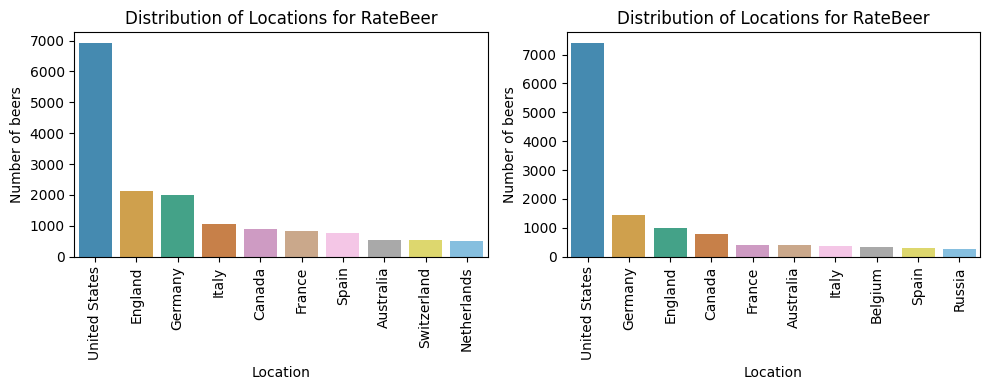

In [19]:
def filtering_us(breweries_df, number_of_beer_per_country):
    # Create a category that gathers all the US beers in one location
    # Count number of beers in the US
    nb_us_beers = breweries_df[breweries_df['location'].str.startswith('United States,')].value_counts().sum()

    # Modify world wide beer count to gather all the US beers in one category 
    us_filtered = number_of_beer_per_country[~number_of_beer_per_country.index.str.startswith('United States,')]
    us_filtered.loc['United States'] = nb_us_beers

    us_filtered = us_filtered.nlargest(10)
    return us_filtered

us_filtered_RB = filtering_us(breweries_RB, number_of_beer_per_country_RB)
us_filtered_BA = filtering_us(breweries_BA, number_of_beer_per_country_BA)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=us_filtered_RB.index, y=us_filtered_RB.values, alpha=0.8, palette=sns.color_palette("colorblind"))
plt.title('Distribution of Locations for RateBeer')
plt.ylabel('Number of beers')
plt.xlabel('Location')
plt.xticks(rotation=90) 

plt.subplot(1, 2, 2)
sns.barplot(x=us_filtered_BA.index, y=us_filtered_BA.values, alpha=0.8, palette=sns.color_palette("colorblind"))
plt.title('Distribution of Locations for RateBeer')
plt.ylabel('Number of beers')
plt.xlabel('Location')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [20]:
us_filtered_RB.head() # doesnot filter dataframe

location
United States    6921
England          2124
Germany          1999
Italy            1051
Canada            884
Name: count, dtype: int64

In [21]:
# Plot the entire distribution of locations

#fig, axs = plt.subplots(1,2, figsize=(10, 50))
#sns.countplot(y='location', data = us_filtered_BA, palette=sns.color_palette("colorblind"), ax = axs[0])
#sns.countplot(y='location', data = us_filtered_RB, palette=sns.color_palette("colorblind"), ax = axs[1])
#plt.title('Distribution of Locations')
#plt.xlabel('Number of beers')
#plt.ylabel('Location')
#plt.xticks(rotation=45) 
#plt.show()

- Categorical features (except textual reviews)
    - beer_name
    - brewery_name
    - style
    - date
    - review (for BeerAdvocate only)

In [22]:
# todo

**Ratings** dataframes

TODO : add explanation why we can only visualize 5% of the breweries

Number of different breweries in BA : 1962
Number of different breweries in RB : 1942


C:\Users\julie\AppData\Local\Temp\ipykernel_15892\3092435842.py:28: UserWarning: Glyph 146 (\x92) missing from current font.
  plt.tight_layout()
C:\Users\julie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


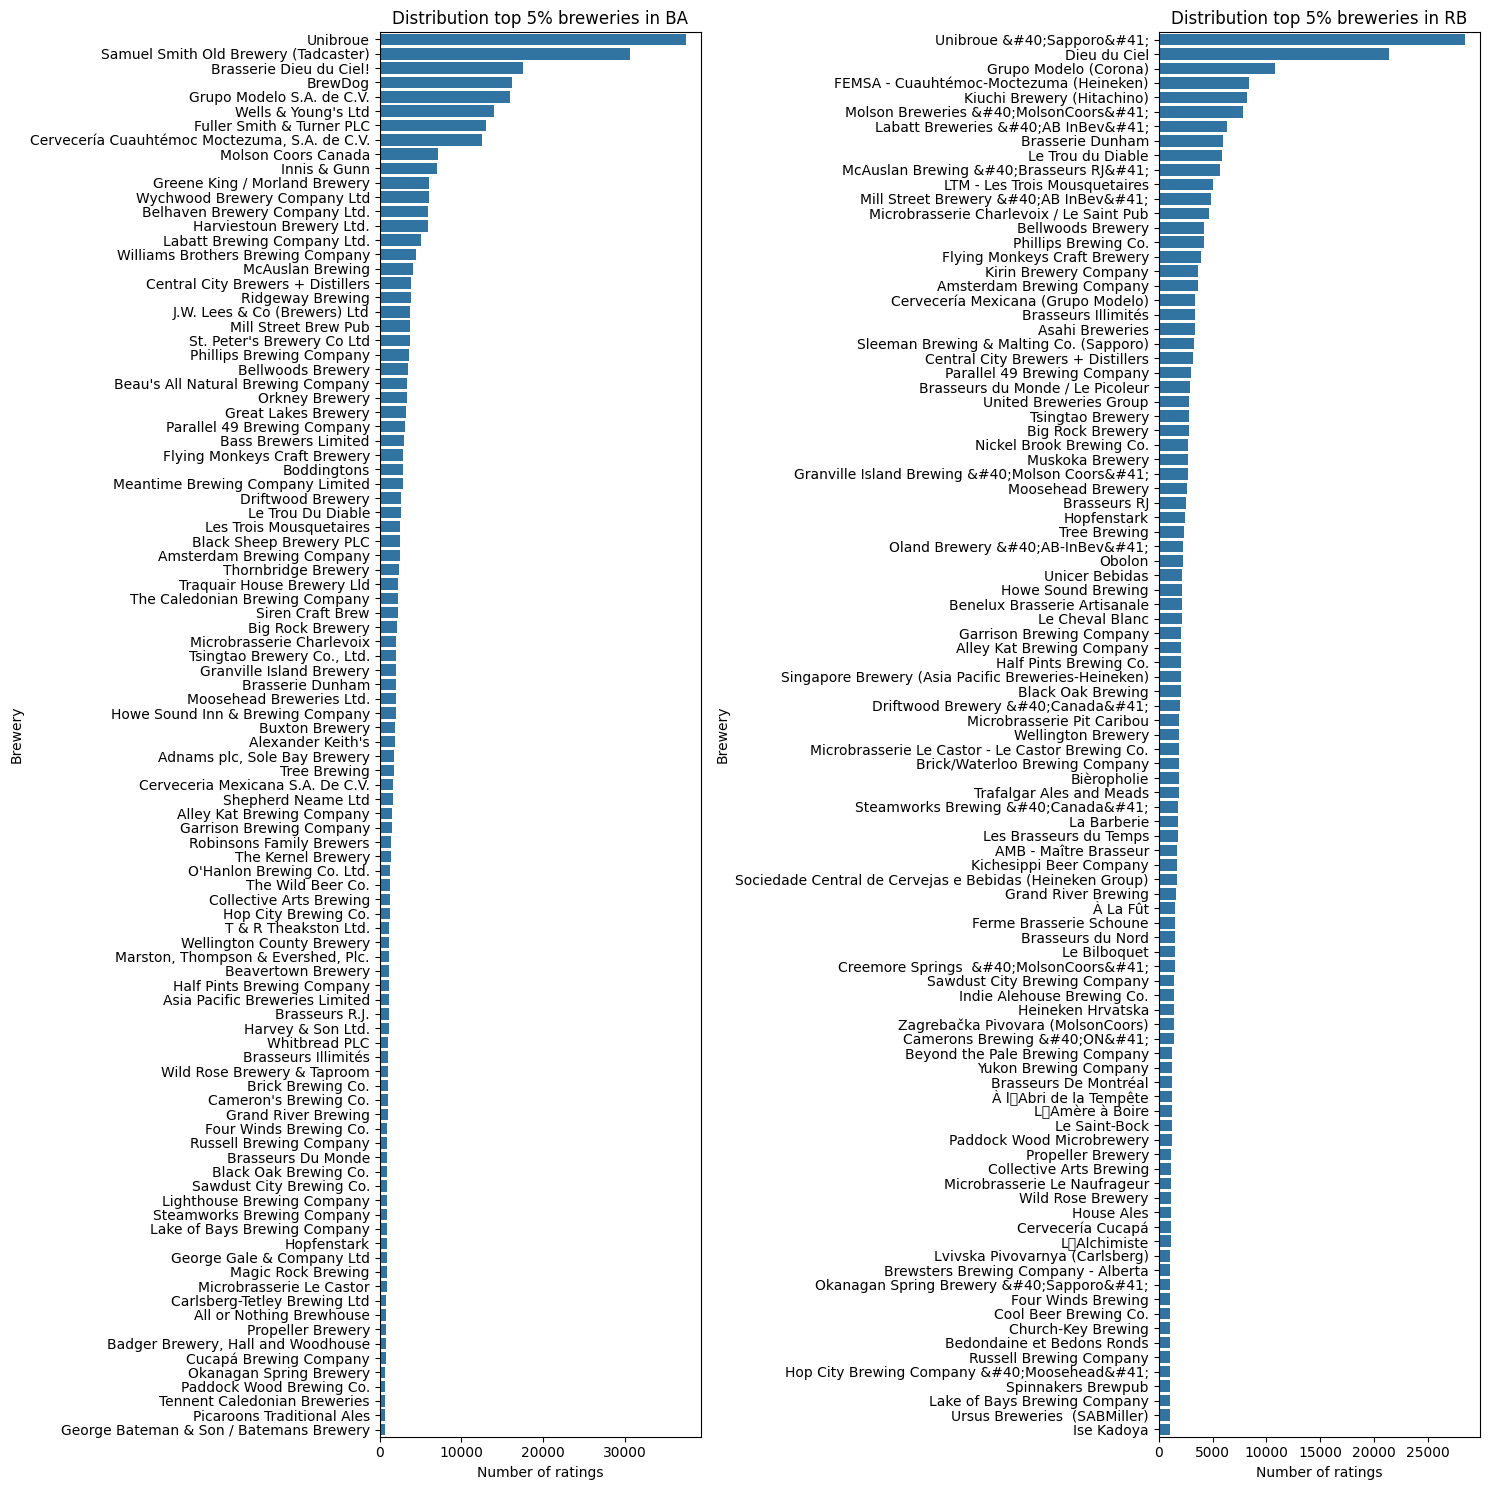

In [23]:
print(f"Number of different breweries in BA : {len(ratings_BA['brewery_id'].unique())}")
print(f"Number of different breweries in RB : {len(ratings_RB['brewery_id'].unique())}")

def filter_topk_breweries(df, k):
    # Find the top k% of breweries most rated
    brewery_count = pd.DataFrame({"count": df.groupby('brewery_name').apply(lambda x: len(x))})
    threshold = brewery_count['count'].quantile(k)
    top_breweries = brewery_count[brewery_count['count'] > threshold].index

    # Filter DataFrame based on the selected brewery names
    df_filtered = df[df['brewery_name'].isin(top_breweries)]
    return df_filtered

ratings_BA_top5_breweries = filter_topk_breweries(ratings_BA, 0.95)
ratings_RB_top5_breweries = filter_topk_breweries(ratings_RB, 0.95)

fig, axs = plt.subplots(1,2, figsize=(15, 15))
sns.countplot(y='brewery_name', data = ratings_BA_top5_breweries, order = ratings_BA_top5_breweries['brewery_name'].value_counts().index, ax = axs[0])
sns.countplot(y='brewery_name', data = ratings_RB_top5_breweries, order = ratings_RB_top5_breweries['brewery_name'].value_counts().index, ax = axs[1])

axs[0].set_title("Distribution top 5% breweries in BA")
axs[1].set_title("Distribution top 5% breweries in RB")

for ax in axs.flat:
    ax.set_xlabel("Number of ratings")
    ax.set_ylabel("Brewery")

plt.tight_layout()
plt.show()

**Style**

Number of different style of beers in BA : 105
Number of different style of beers in RB : 90


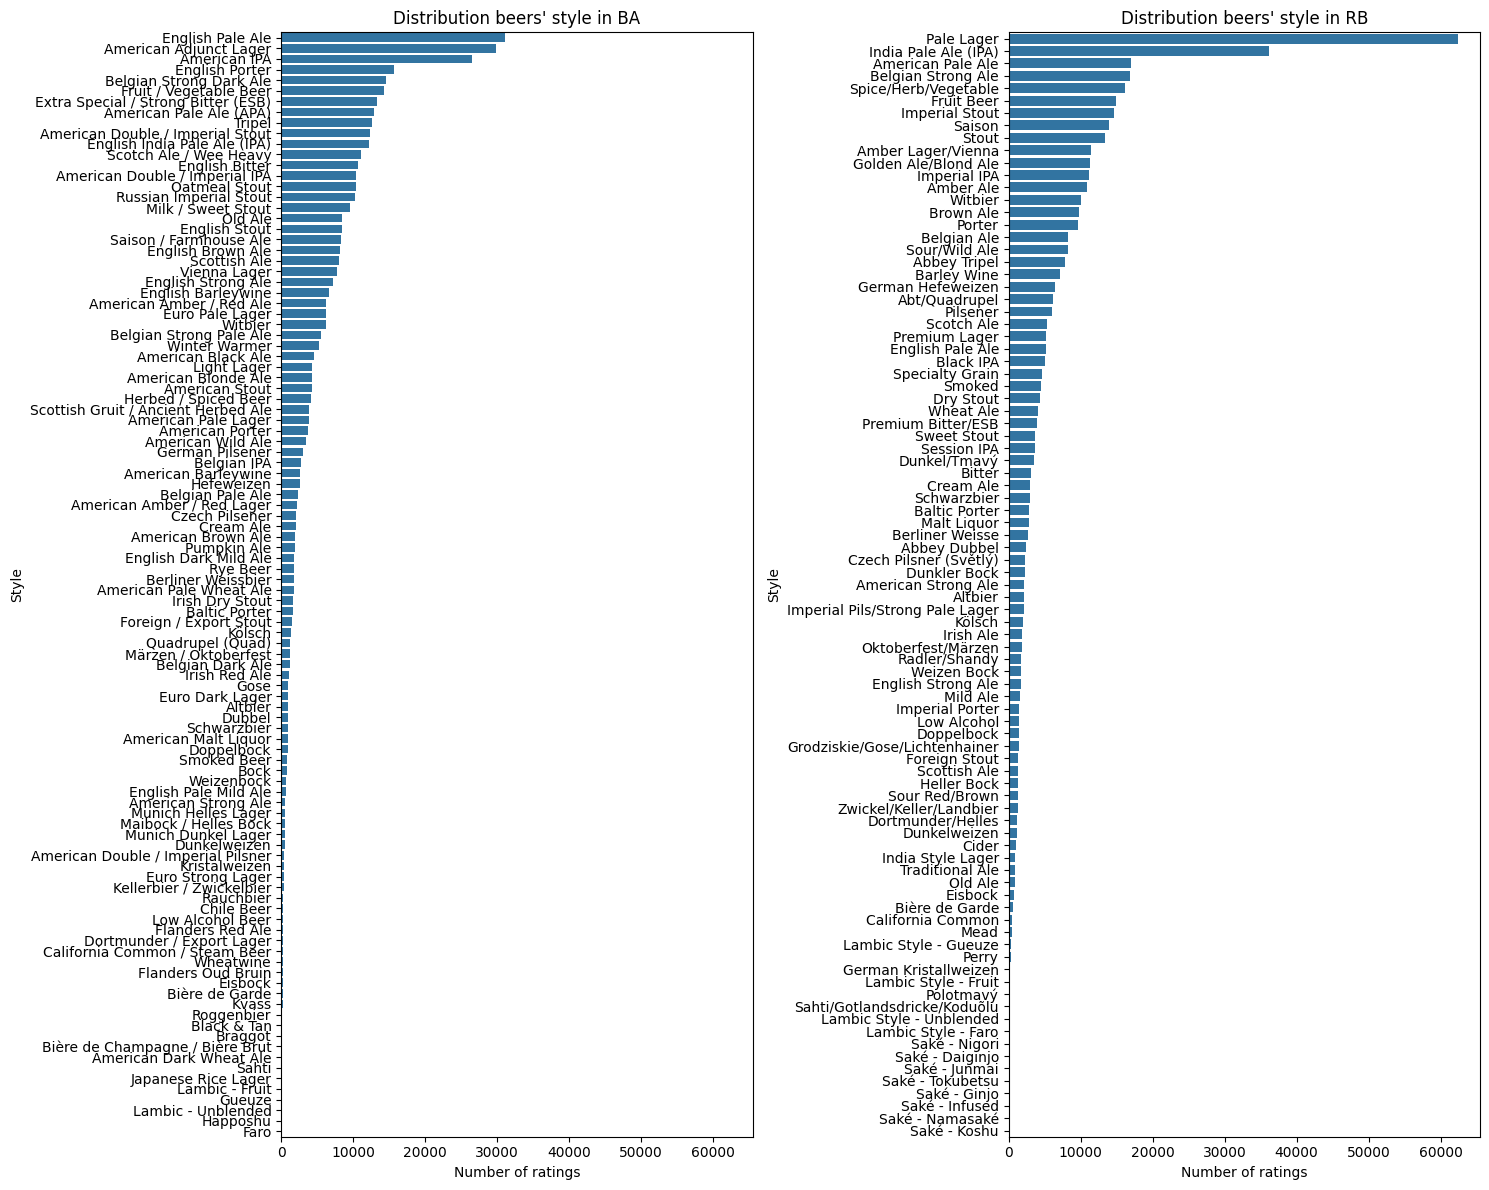

In [24]:
print(f"Number of different style of beers in BA : {len(ratings_BA['style'].unique())}")
print(f"Number of different style of beers in RB : {len(ratings_RB['style'].unique())}")

fig, axs = plt.subplots(1,2, figsize=(15, 12), sharex = True)
sns.countplot(y='style', data=ratings_BA, order = ratings_BA['style'].value_counts().index,ax = axs[0])
sns.countplot(y='style', data=ratings_RB, order = ratings_RB['style'].value_counts().index,ax = axs[1])

axs[0].set_title("Distribution beers' style in BA")
axs[1].set_title("Distribution beers' style in RB")

for ax in axs.flat:
    ax.set_xlabel("Number of ratings")
    ax.set_ylabel("Style")

plt.tight_layout()
plt.show()

In the following cell, we define a function `filter_topk_styles` that will allow us to plot only the styles most represented in the dataset.

In [25]:
def filter_topk_styles(df, k):
    # Find the top k% of breweries most rated
    style_count = pd.DataFrame({"count": df.groupby('style').apply(lambda x: len(x))})
    threshold = style_count['count'].quantile(k)
    top_styles = style_count[style_count['count'] > threshold].index

    # Filter DataFrame based on the selected brewery names
    df_filtered = df[df['style'].isin(top_styles)]
    return df_filtered

- Numerical features
    - abv
    - appearance
    - aroma
    - palate
    - taste
    - overall
    - rating

**Univariate analysis**

In [26]:
def plot_features(df, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating'] #list(df._get_numeric_data().columns)
    fig, axes = plt.subplots(2, 4, figsize=(15,10))
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        data = df[~df[col].isna()]
        sns.histplot(data=data[col], bins=50, ax=ax) #Filter out nan values in the features
    fig.suptitle(title)
    fig.tight_layout()
    return fig

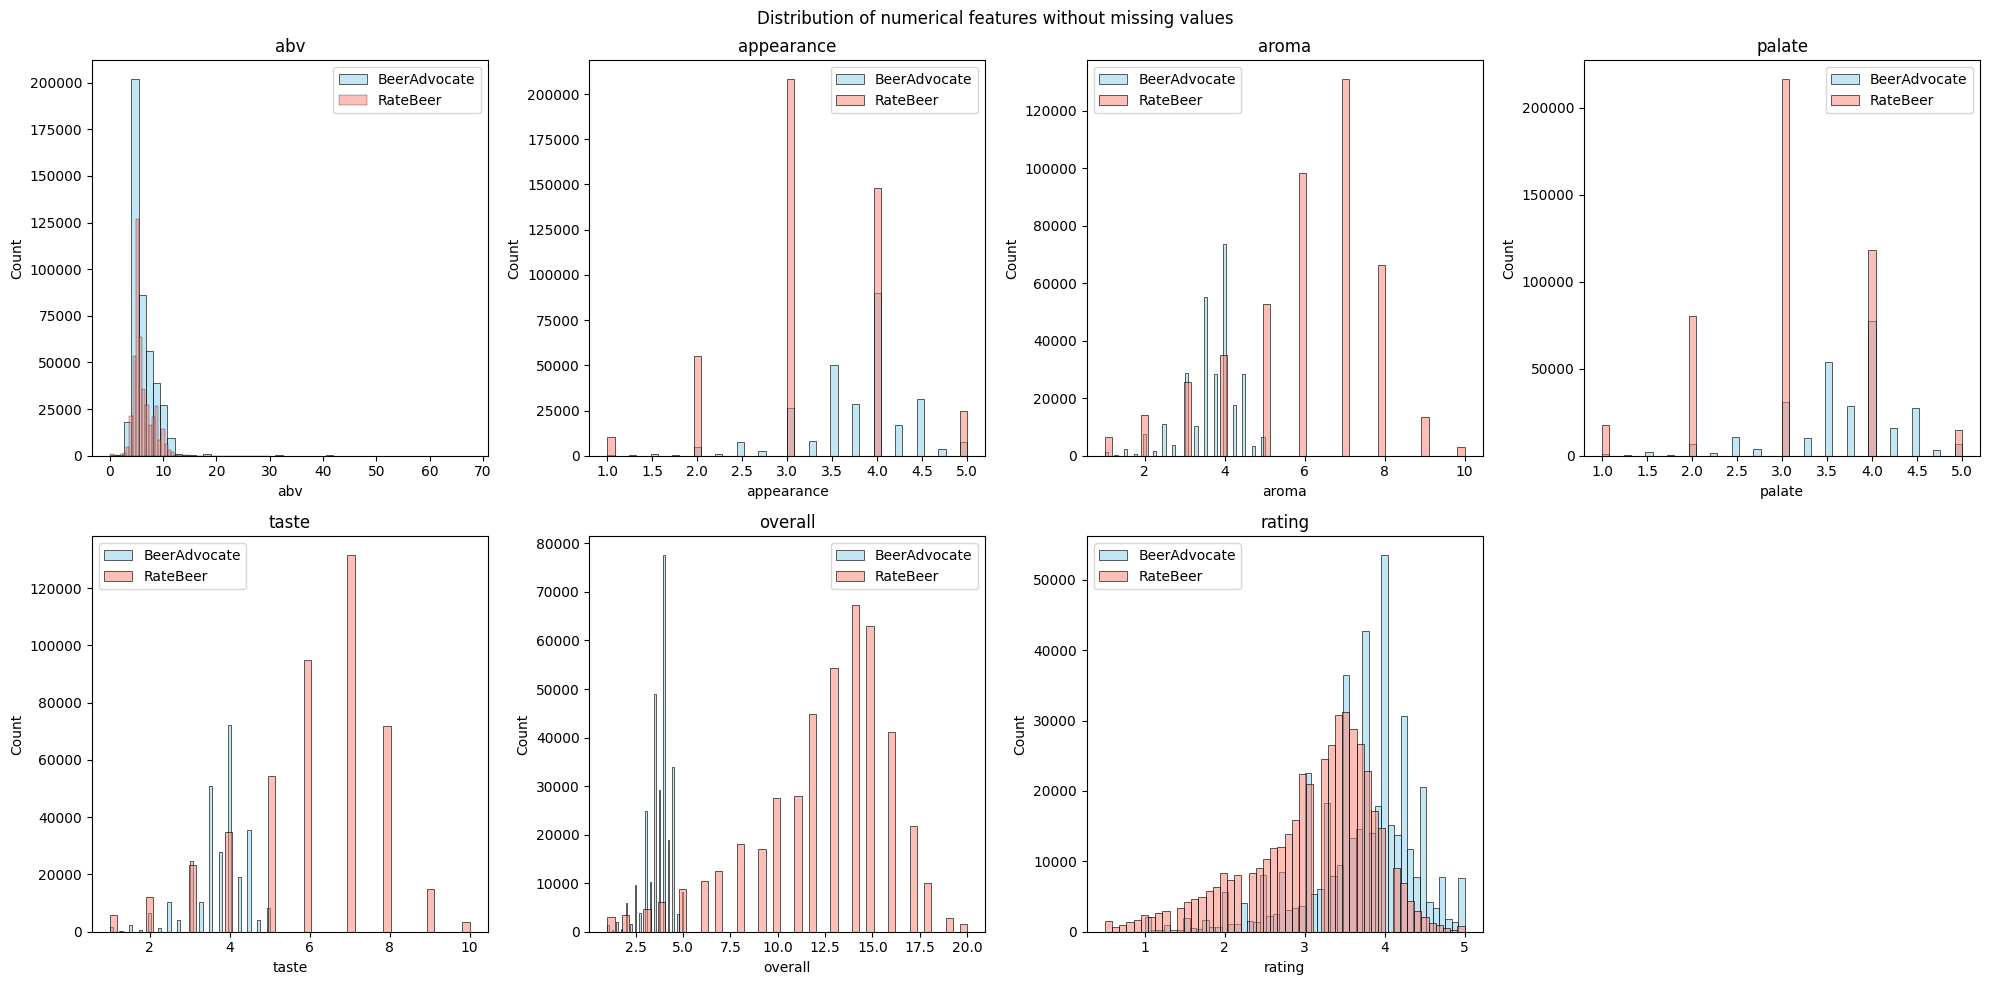

In [27]:
def plot_features(df1, df2, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
    fig, axes = plt.subplots(2, 4, figsize=(20,10))
    fig.delaxes(axes[1, 3])
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        sns.histplot(data=df1[~df1[col].isna()], x=col, bins=50, ax=ax, color='skyblue', alpha=0.5, label='BeerAdvocate')
        sns.histplot(data=df2[~df2[col].isna()], x=col, bins=50, ax=ax, color='salmon', alpha=0.5, label='RateBeer')
        ax.set_title(col)
        ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    return fig

# Assuming ratings_BA and ratings_RB are DataFrames with the same columns
fig = plot_features(ratings_BA, ratings_RB, "Distribution of numerical features without missing values")
plt.show()

This mosaique plots highlights the differences in the notation between the two websites. Especially in teh appearance and palate categories: RateBeer users are not allowed to put non integer values. This is not the case for BeerAdvocate users. This is why the distribution of the RateBeer ratings is more discrete than the BeerAdvocate one.
One another side, the overall ratings in RateBeer and BeerAdvocate are not on the same scales: 5-scale for BeerAdvocate and 20-scale for RateBeer.

Later on in this notebooks, the values will be normalized for better comparison.

- per style
- per brewery

**Multivariate analysis**

- Scores - styles

NB : redo it with ratings files ? Here has been done with beers.cvs !!

C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1271778447.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=beers_BA.groupby('style')['avg_computed'].mean().sort_values(ascending=False).head(20).index,
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1271778447.py:5: UserWarning: 
The palette list has fewer values (10) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=beers_BA.groupby('style')['avg_computed'].mean().sort_values(ascending=False).head(20).index,
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1271778447.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=beers_RB.groupby('style')['avg_computed'].mean().sort_values(ascend

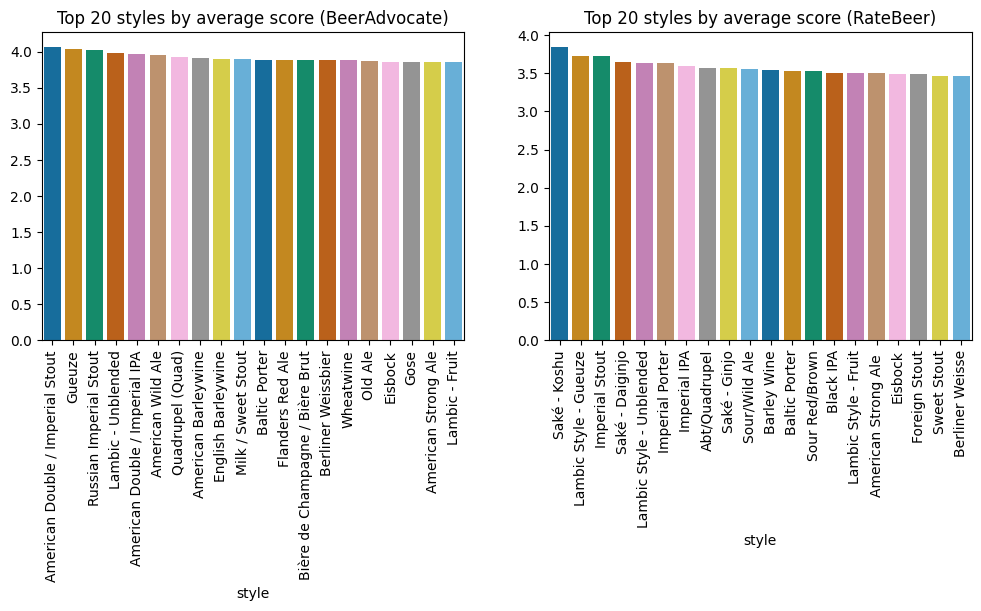

In [28]:
plt.figure(figsize=(12, 4))

# Best rated styles for BeerAdvocate
plt.subplot(1, 2, 1)
sns.barplot(x=beers_BA.groupby('style')['avg_computed'].mean().sort_values(ascending=False).head(20).index,
            y=beers_BA.groupby('style')['avg_computed'].mean().sort_values(ascending=False).head(20).values, palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)
plt.title('Top 20 styles by average score (BeerAdvocate)')

# Best rated styles for RateBeer 
plt.subplot(1, 2, 2)
sns.barplot(x=beers_RB.groupby('style')['avg_computed'].mean().sort_values(ascending=False).head(20).index,
            y=beers_RB.groupby('style')['avg_computed'].mean().sort_values(ascending=False).head(20).values, palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)
plt.title('Top 20 styles by average score (RateBeer)')

plt.show()

C:\Users\julie\AppData\Local\Temp\ipykernel_15892\2231409079.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='style', y='avg_computed', data=beers_BA[beers_BA['style'].isin(style_order_BA)], order=style_order_BA, palette=sns.color_palette("colorblind"))
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\2231409079.py:15: UserWarning: 
The palette list has fewer values (10) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='style', y='avg_computed', data=beers_BA[beers_BA['style'].isin(style_order_BA)], order=style_order_BA, palette=sns.color_palette("colorblind"))
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\2231409079.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` f

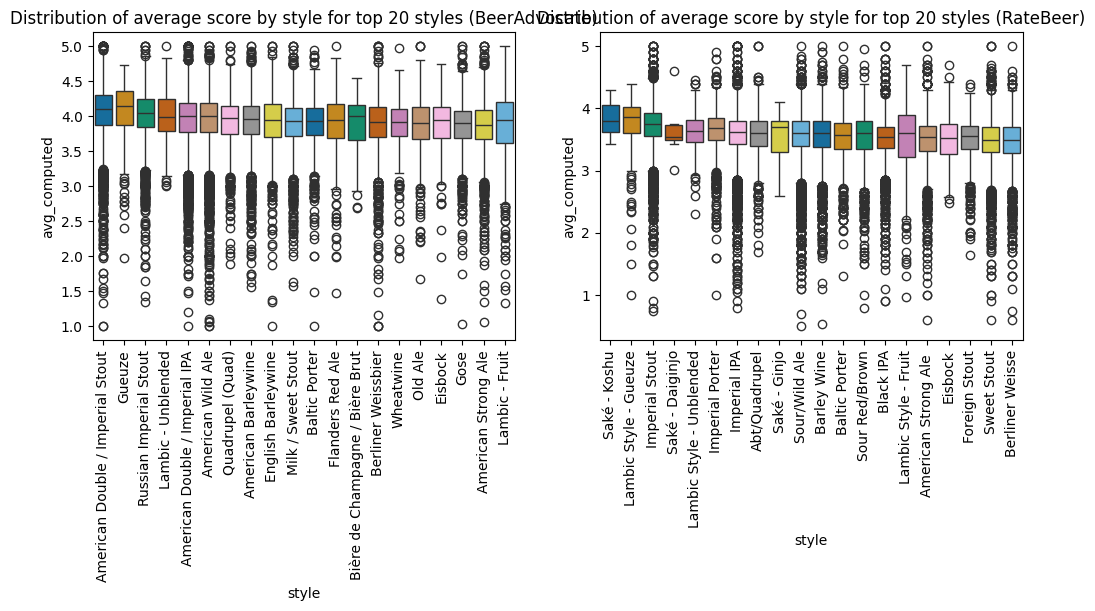

In [29]:
# Calculate the average score for each style and take the top 20 for RateBeer

def style_order_fcn(beers_df):
    style_order = beers_df.groupby('style')['avg_computed'].mean().sort_values(ascending=False).head(20).index
    return style_order

style_order_BA = style_order_fcn(beers_BA)
style_order_RB = style_order_fcn(beers_RB)

# Create the boxplots
plt.figure(figsize=(12, 4))

# Create the boxplot for BeerAdvocate
plt.subplot(1, 2, 1)
sns.boxplot(x='style', y='avg_computed', data=beers_BA[beers_BA['style'].isin(style_order_BA)], order=style_order_BA, palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)
plt.title('Distribution of average score by style for top 20 styles (BeerAdvocate)')

# Create the boxplot for RateBeer
plt.subplot(1, 2, 2)
sns.boxplot(x='style', y='avg_computed', data=beers_RB[beers_RB['style'].isin(style_order_RB)], order=style_order_RB, palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)
plt.title('Distribution of average score by style for top 20 styles (RateBeer)')

plt.show()

- Scores - breweries

C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1899778266.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='brewery_name', y='count', data=top_breweries_BA, palette=sns.color_palette("colorblind"))
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1899778266.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='brewery_name', y='count', data=top_breweries_RB, palette=sns.color_palette("colorblind"))
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1899778266.py:35: UserWarning: Glyph 146 (\x92) missing from current font.
  plt.tight_layout()
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1899778266.py:35: UserWarning: Tight layout not applied. The bottom and top margins cann

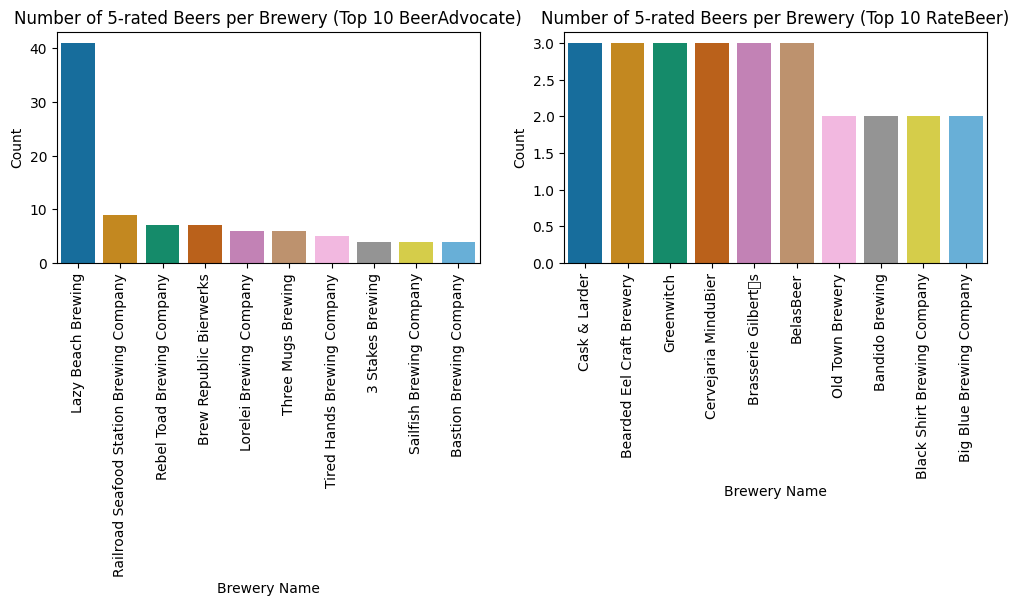

In [30]:
def top_breweries_fcn(beers_df):
    #Identify breweries with most 5 rated beers for RateBeer
    beer_score_5 = beers_df[beers_df['avg_computed'] == 5]
    # Count the occurrences of each brewery
    brewery_counts = beer_score_5['brewery_name'].value_counts().nlargest(10)

    # Create a DataFrame with the top 10 breweries and their counts
    top_breweries = pd.DataFrame({'brewery_name': brewery_counts.index, 'count': brewery_counts.values})
    return top_breweries, beer_score_5

top_breweries_BA, _ = top_breweries_fcn(beers_BA)
top_breweries_RB, _ = top_breweries_fcn(beers_RB)

_ , beer_score_5_BA = top_breweries_fcn(beers_BA)
_ , beer_score_5_RB = top_breweries_fcn(beers_RB)

# Create the barplots
plt.figure(figsize=(12, 3))

# Create a barplot for BeerAdvocate
plt.subplot(1, 2, 1)
sns.barplot(x='brewery_name', y='count', data=top_breweries_BA, palette=sns.color_palette("colorblind"))
plt.title('Number of 5-rated Beers per Brewery (Top 10 BeerAdvocate)')
plt.xlabel('Brewery Name')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Create a barplot for RateBeer
plt.subplot(1, 2, 2)
sns.barplot(x='brewery_name', y='count', data=top_breweries_RB, palette=sns.color_palette("colorblind"))
plt.title('Number of 5-rated Beers per Brewery (Top 10 RateBeer)')
plt.xlabel('Brewery Name')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

C:\Users\julie\AppData\Local\Temp\ipykernel_15892\70270512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breweries_5.rename(columns={'name': 'brewery_name'}, inplace=True)
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\70270512.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breweries_5.rename(columns={'name': 'brewery_name'}, inplace=True)
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\70270512.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='brew

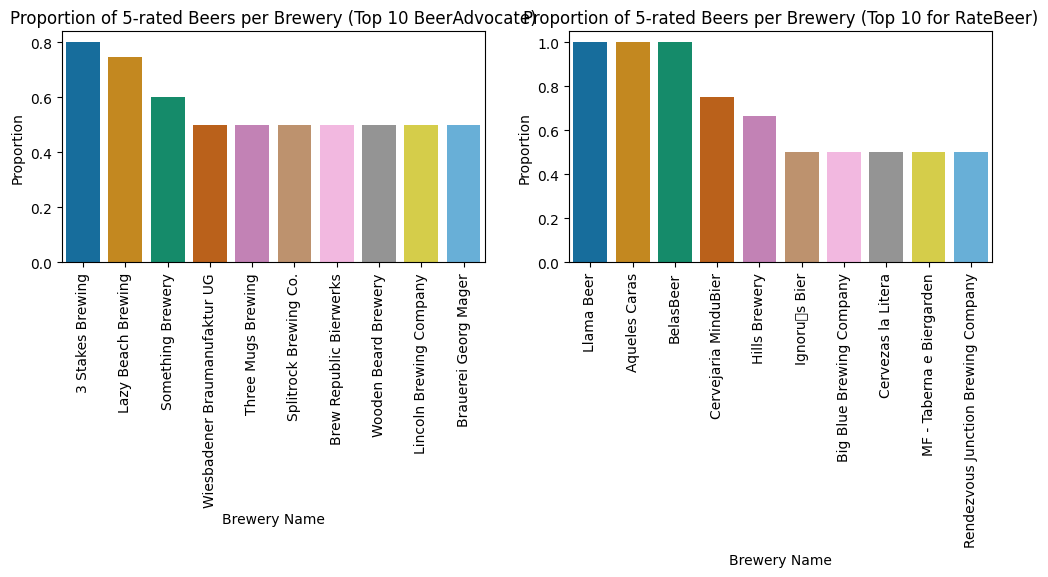

In [31]:
def top_10_proportion(breweries_df, beer_score_5):
    # Create dataframe for breweries with 5 rated beers
    breweries_5 = breweries_df[breweries_df['id'].isin(beer_score_5['brewery_id'])]
    breweries_5.rename(columns={'name': 'brewery_name'}, inplace=True)

    # Isolate brewery infos 
    brewery_counts_all = beer_score_5['brewery_name'].value_counts()
    brewery_count_df = pd.DataFrame({'brewery_name': brewery_counts_all.index, 'count': brewery_counts_all.values})

    # Determining the proportion of 5 rated beers
    # Merge DataFrames on the 'brewery_name' column
    proportion_of_5_df = pd.merge(breweries_5, brewery_count_df, on='brewery_name', how='inner')

    # Exclude breweries with less than 2 beers to get meaningful proportions
    proportion_of_5_df = proportion_of_5_df[proportion_of_5_df['nbr_beers'] >= 2]

    # Perform division
    proportion_of_5_df['proportion'] = proportion_of_5_df['count'] / proportion_of_5_df['nbr_beers']

    # Taking Top 10 breweries
    Top_10_breweries = proportion_of_5_df.sort_values('proportion', ascending=False).head(10)
    
    return Top_10_breweries

Top_10_breweries_BA = top_10_proportion(breweries_BA, beer_score_5_BA)
Top_10_breweries_RB = top_10_proportion(breweries_RB, beer_score_5_RB)

# Create a histogram of the top 10 breweries with the most 5 rated beers ordered by proportion
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
sns.barplot(x='brewery_name', y='proportion', data=Top_10_breweries_BA, palette=sns.color_palette("colorblind"))
plt.title('Proportion of 5-rated Beers per Brewery (Top 10 BeerAdvocate)')
plt.xlabel('Brewery Name')
plt.xticks(rotation=90)
plt.ylabel('Proportion')

plt.subplot(1, 2, 2)
sns.barplot(x='brewery_name', y='proportion', data=Top_10_breweries_RB, palette=sns.color_palette("colorblind"))
plt.title('Proportion of 5-rated Beers per Brewery (Top 10 for RateBeer)')
plt.xlabel('Brewery Name')
plt.xticks(rotation=90)
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

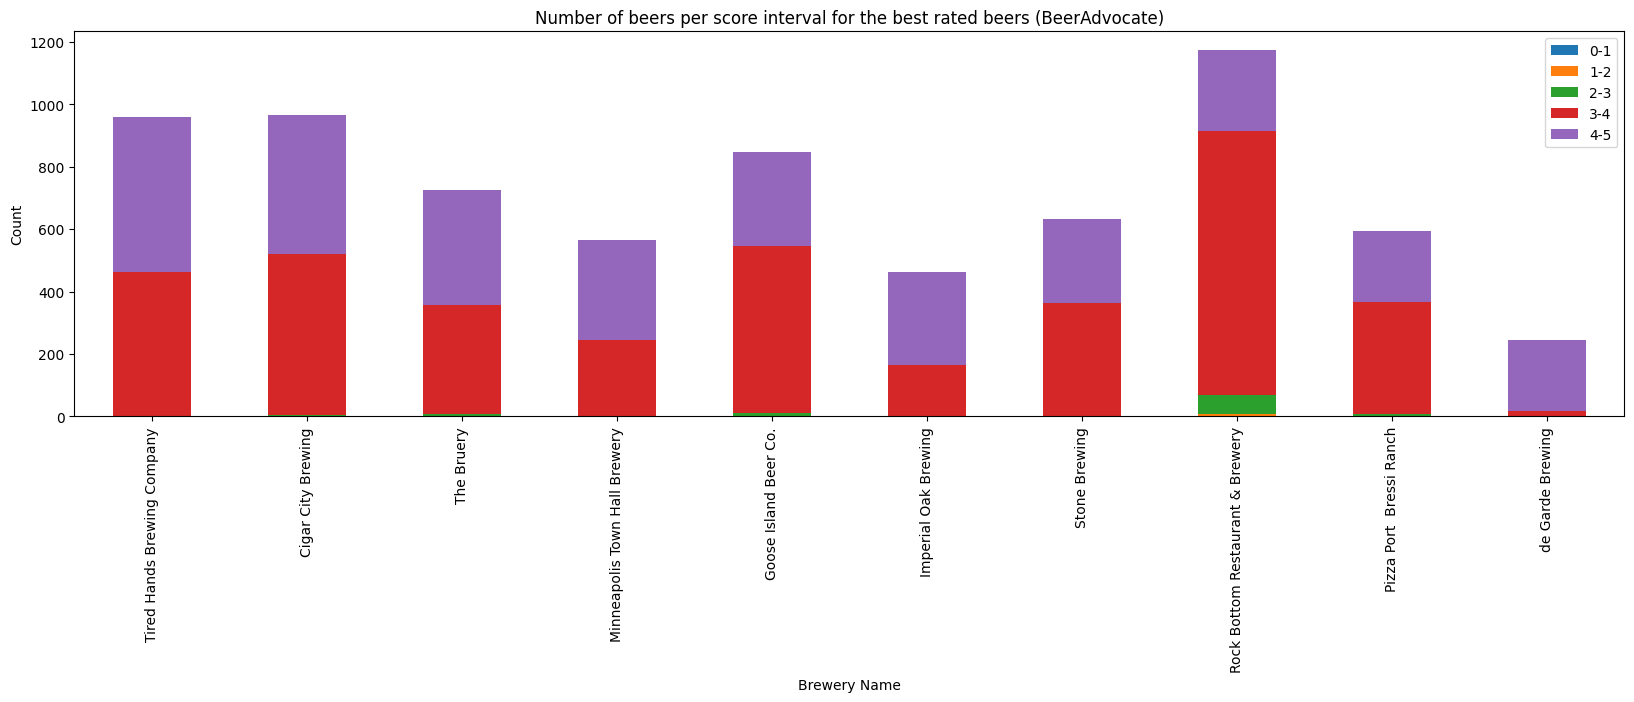

<Figure size 1000x500 with 0 Axes>

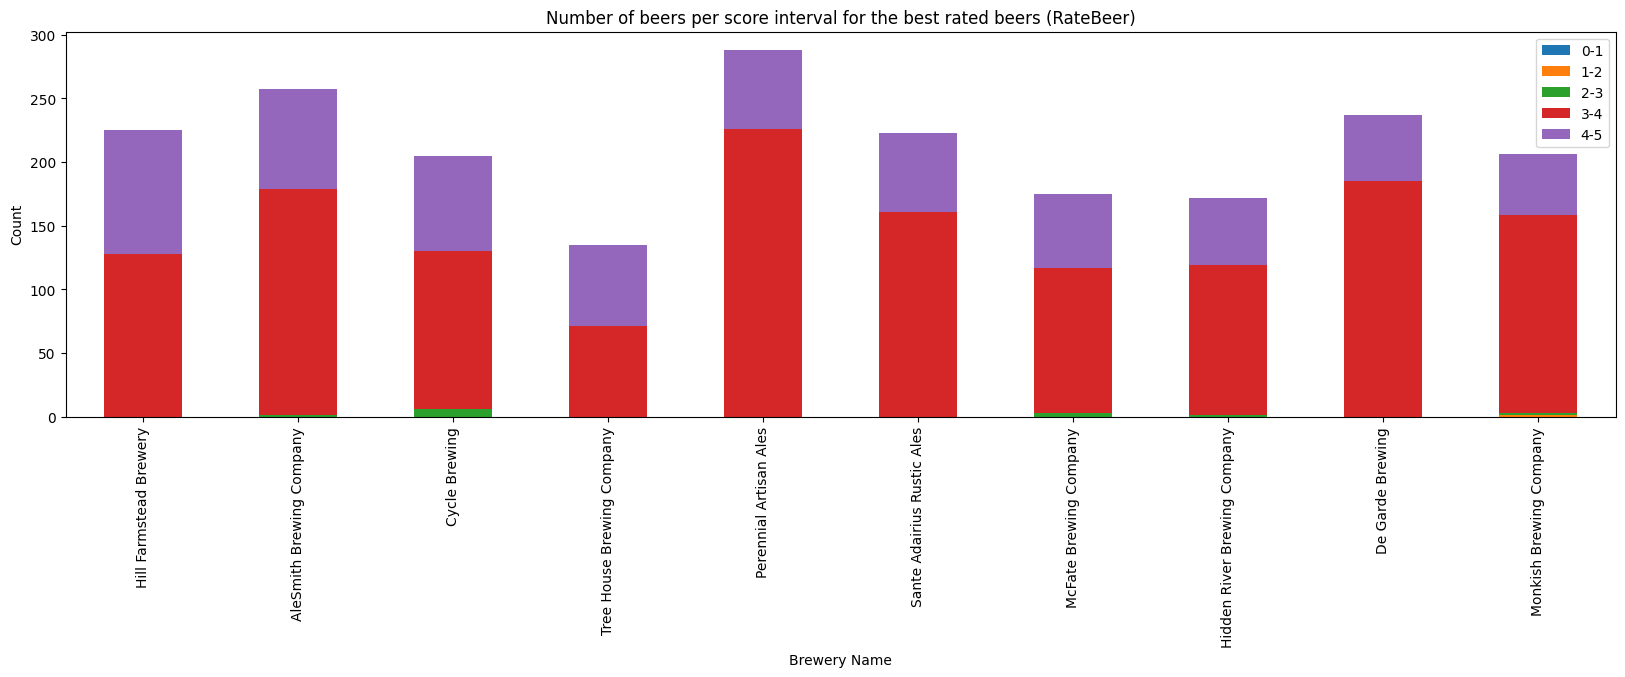

In [32]:
# Count the number of beers per rating interval
def count_beers_per_rating_interval(beers_df):
    beers_score =[]
    brewery_counts = []
    for i in range(5):
        beers_score.append(beers_df[(i < beers_df['avg_computed']) & (beers_df['avg_computed'] <= i+1)])
        brewery_counts.append(beers_score[i]['brewery_name'].value_counts().sort_index())
    return brewery_counts

breweries_rating_counts_BA = count_beers_per_rating_interval(beers_BA)
breweries_rating_counts_RB = count_beers_per_rating_interval(beers_RB)

# Dataframe with the number of beers per rating interval matched with the brewery name
# Create a dataframe with the different lists in breweries_rating_counts_BA as columns matching in the brewery name for the rows
def breweries_rating_counts(beers_df):
    breweries_rating_counts = pd.concat(count_beers_per_rating_interval(beers_df), axis=1, keys=['0-1', '1-2', '2-3', '3-4', '4-5'])
    breweries_rating_counts.index.name = 'Brewery Name'
    breweries_rating_counts.fillna(0, inplace=True)
    breweries_rating_counts = breweries_rating_counts.astype(int)
    return breweries_rating_counts

df_breweries_rating_counts_BA = breweries_rating_counts(beers_BA)
df_breweries_rating_counts_RB = breweries_rating_counts(beers_RB)

# Create a stacked barplot for the number of beers per rating interval for BeerAdvocate
plt.figure(figsize=(10, 5))
df_breweries_rating_counts_BA.sort_values(by='4-5', ascending=False).iloc[:10].plot.bar(stacked=True, figsize=(20, 5), rot=90)
plt.title('Number of beers per score interval for the best rated beers (BeerAdvocate)')
plt.xlabel('Brewery Name')
plt.ylabel('Count')
plt.show()

# Create a stacked barplot for the number of beers per rating interval for RateBeer
plt.figure(figsize=(10, 5))
df_breweries_rating_counts_RB.sort_values(by='4-5', ascending=False).iloc[:10].plot.bar(stacked=True, figsize=(20, 5), rot=90)
plt.title('Number of beers per score interval for the best rated beers (RateBeer)')
plt.xlabel('Brewery Name')
plt.ylabel('Count')
plt.show()

- Correlations

In [33]:
def calculate_correlations(df1, df2):
        """
        Calculates the correlation between all numerical features.
        
        Parameters
        ----------
        df1 : DataFrame
                First dataframe containing all data
        df2 : DataFrame
                Second dataframe containing all data

        Returns
        -------
        None
        """
        numerical_cols1 = df1.select_dtypes(include=['float64', 'int64']).columns
        corr1 = df1[numerical_cols1].corr()

        numerical_cols2 = df2.select_dtypes(include=['float64', 'int64']).columns
        corr2 = df2[numerical_cols2].corr()

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        sns.heatmap(corr1, annot=True, ax=axes[0])
        sns.heatmap(corr2, annot=True, ax=axes[1])
        axes[0].set_title('Correlation between numerical features in df1')
        axes[1].set_title('Correlation between numerical features in df2')
        plt.show()


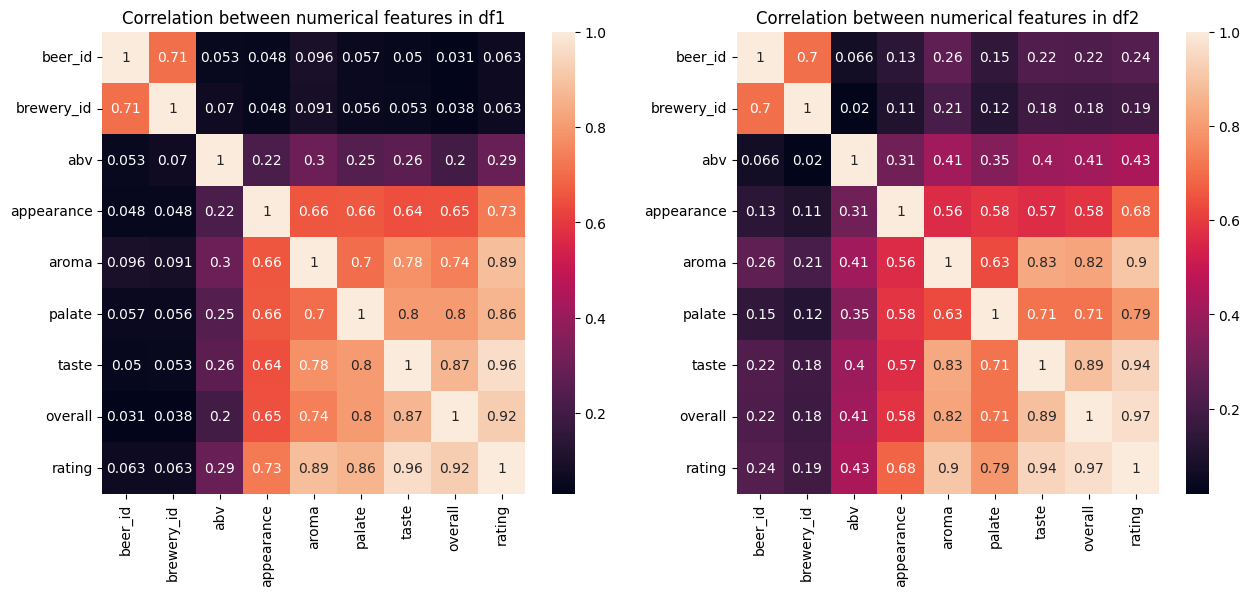

In [34]:
calculate_correlations(ratings_BA, ratings_RB)

Performing correlation heklp having a better understanding of the beer rating. The lower right areas of the matrices look warmer, translating a high correlation between features. Looking a the rating, from the matrices one can see that a beer rater tends to put high rate scores to tastier, and more complex beers.

On difference is that between the 2 websites the correlations are different specially in the apperance where BeerAdvocate users look like they are more fucsed towards it when rating the beverage.

Side note: beer_id brewery_id correlation ????

To go deeper in understanding the correlation, we can look at the joint distribution for the correlated features.

In [35]:
def clipp_df_for_high_corr(df):
    # Select only the numerical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    corr = df[numerical_cols].corr()

    # Select the features with a correlation above 0.5, excluding columns with "id" in their name
    high_corr_cols = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > 0.5:
                colname = corr.columns[i]
                if "id" not in colname:
                    high_corr_cols.append(colname)

    # Drop the features with a correlation below 0.5
    high_corr_cols = list(set(high_corr_cols))
    df_high_corr = df[high_corr_cols]

    return df_high_corr

In [36]:
ratings_BA_correlated = clipp_df_for_high_corr(ratings_BA)
ratings_RB_correlated = clipp_df_for_high_corr(ratings_RB)

Let's study the score in a bit more details and compare between the sites

 - Textual reviews

    - Number of words

### add descriptive statistics about textual reviews (number of words in sentences, ...)

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
def get_top_n_i_gram(corpus, i, n=None):
    # drop the rows where there is a NaN value in the 'text' column
    corpus = corpus.dropna()
    vec = CountVectorizer(ngram_range=(i,i)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

Compute the N most common words, bigrams and trigrams in 

In [39]:
# run for 7min approx.
N = 20

# BeerAdvocate
common_unigrams_BA = get_top_n_i_gram(ratings_BA['text'], 1, N)
common_bigrams_BA = get_top_n_i_gram(ratings_BA['text'], 2, N)
common_trigrams_BA = get_top_n_i_gram(ratings_BA['text'], 3, N)
# Rate Beer
common_unigrams_RB = get_top_n_i_gram(ratings_RB['text'], 1, N)
common_bigrams_RB = get_top_n_i_gram(ratings_RB['text'], 2, N)
common_trigrams_RB = get_top_n_i_gram(ratings_RB['text'], 3, N)

In [40]:
def plot_ngrams(common_unigrams, common_bigrams, common_trigrams):
    # Creating subplots
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    # Subplot 1: Common Unigrams
    df1 = pd.DataFrame(common_unigrams, columns=['Review Text', 'count'])
    df1.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[0])
    axes[0].set_title(f'Top {N} words in reviews')

    # Subplot 2: Common Bigrams
    df2 = pd.DataFrame(common_bigrams, columns=['Review Text', 'count'])
    df2.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[1])
    axes[1].set_title(f'Top {N} bigrams in reviews')

    # Subplot 3: Common Trigrams
    df3 = pd.DataFrame(common_trigrams, columns=['Review Text', 'count'])
    df3.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[2])
    axes[2].set_title(f'Top {N} trigrams in reviews')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

##### BeerAdvocate

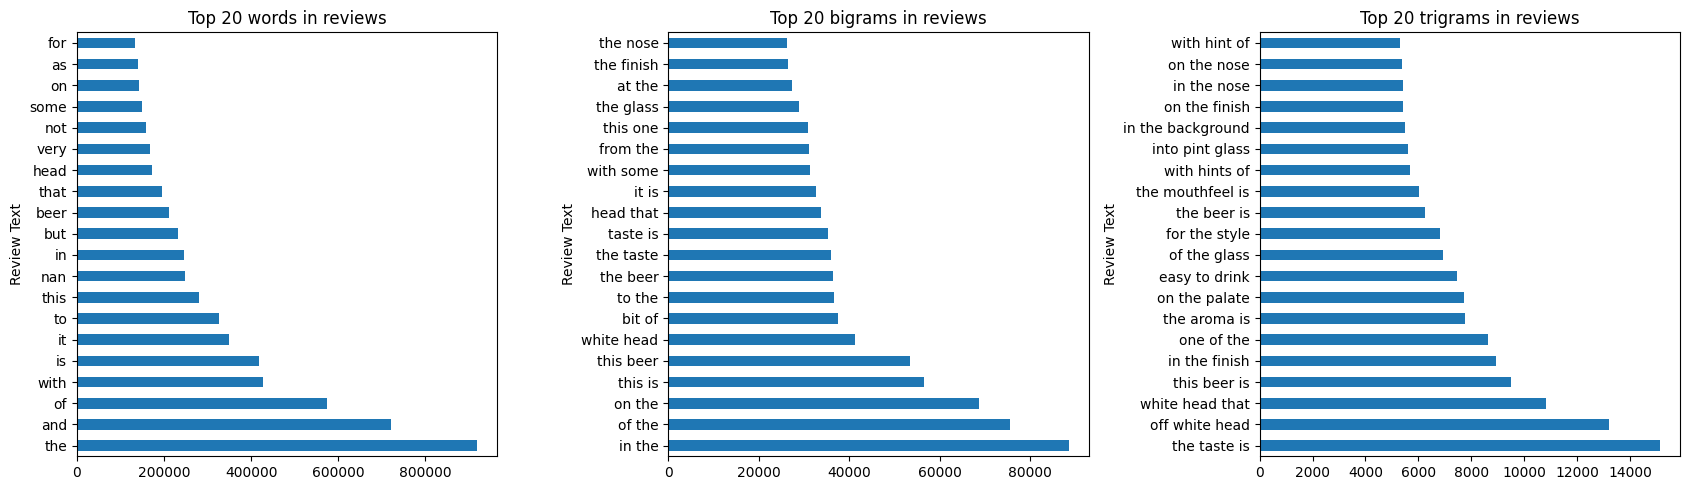

##### RateBeer

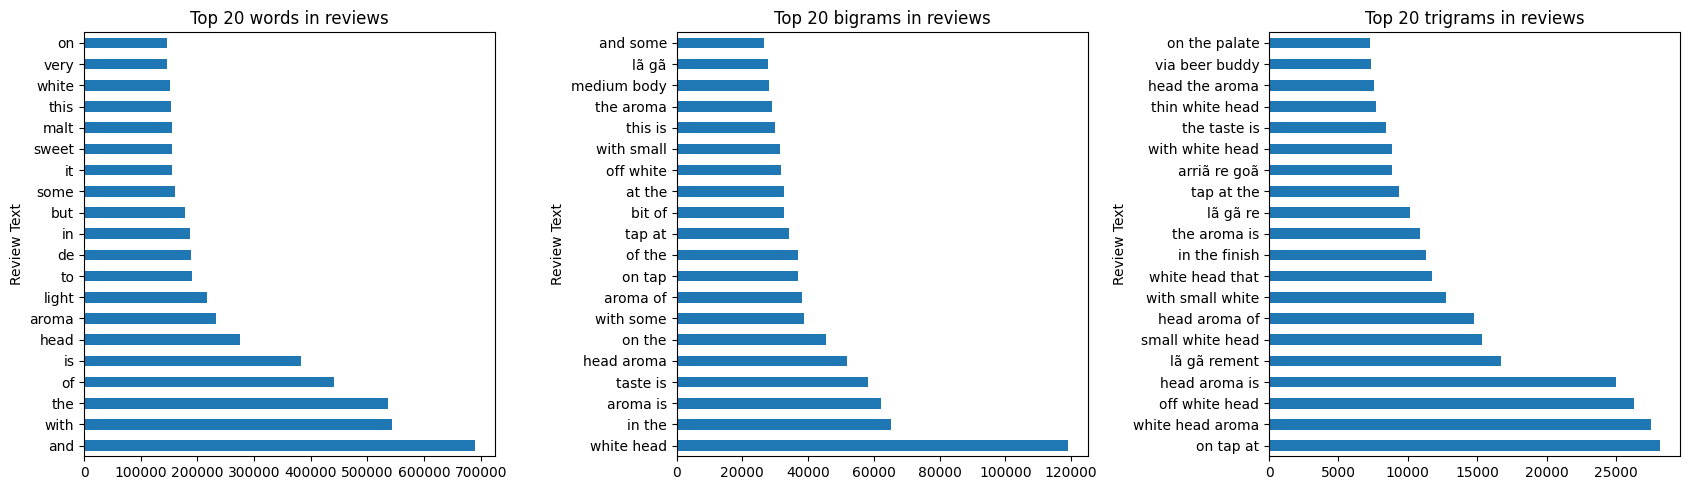

In [41]:
display(Markdown("##### BeerAdvocate"))
plot_ngrams(common_unigrams_BA, common_bigrams_BA, common_trigrams_BA)
display(Markdown("##### RateBeer"))
plot_ngrams(common_unigrams_RB, common_bigrams_RB, common_trigrams_RB)

---

## Data preprocessing

- enrichment
- filtering
- transformation

### Filtering

In [42]:
# todo
# add grid of numerical features with normalization

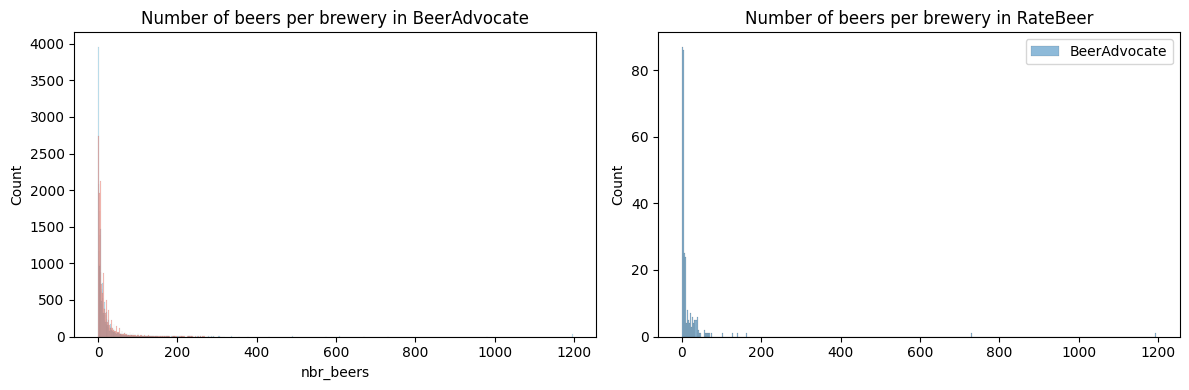

In [43]:
# filter outlier values in breweries dataframe : especially in BA, one brewery has 1200 beers (60 times the mean). Is it an outlier ?

# groupby id
fig, axs = plt.subplots(1,2, figsize = (12,4))
sns.histplot(data = breweries_BA, x = 'nbr_beers', color='skyblue', alpha=0.5, label='BeerAdvocate', ax = axs[0])
sns.histplot(data = breweries_RB, x = 'nbr_beers', color='salmon', alpha=0.5, label='RateBeer', ax = axs[0])


sns.histplot(data = breweries_BA.groupby('location').apply(lambda x: pd.Series({"nbr_beers": x['nbr_beers'].mean()})), color='orange', alpha=0.5, label='BeerAdvocate', ax = axs[1])
#sns.histplot(data = breweries_RB.groupby('location').apply(lambda x: pd.Series({"nbr_beers": x['nbr_beers'].mean()})), color='black', alpha=0.5, label='RateBeer', ax = axs[1])

axs[0].set_title("Number of beers per brewery in BeerAdvocate")
axs[1].set_title("Number of beers per brewery in RateBeer")

plt.legend()
plt.tight_layout()
plt.show()

#groupby location

### Transformation

- Normalization of numerical features

In [44]:
def normalize_numerical_data(df):
    """
    Normalizes the numerical features of the DataFrame.
    
    Parameters
    ----------
    df : DataFrame
        Containing all data

    Returns
    -------
    df : DataFrame
        Containing all data with normalized numerical features.
                
    """
    df2 = df.copy()
    numerical = df2._get_numeric_data().columns
    for col in numerical:
        df2[col] = (df2[col] - df2[col].mean()) / df2[col].std()
    return df2

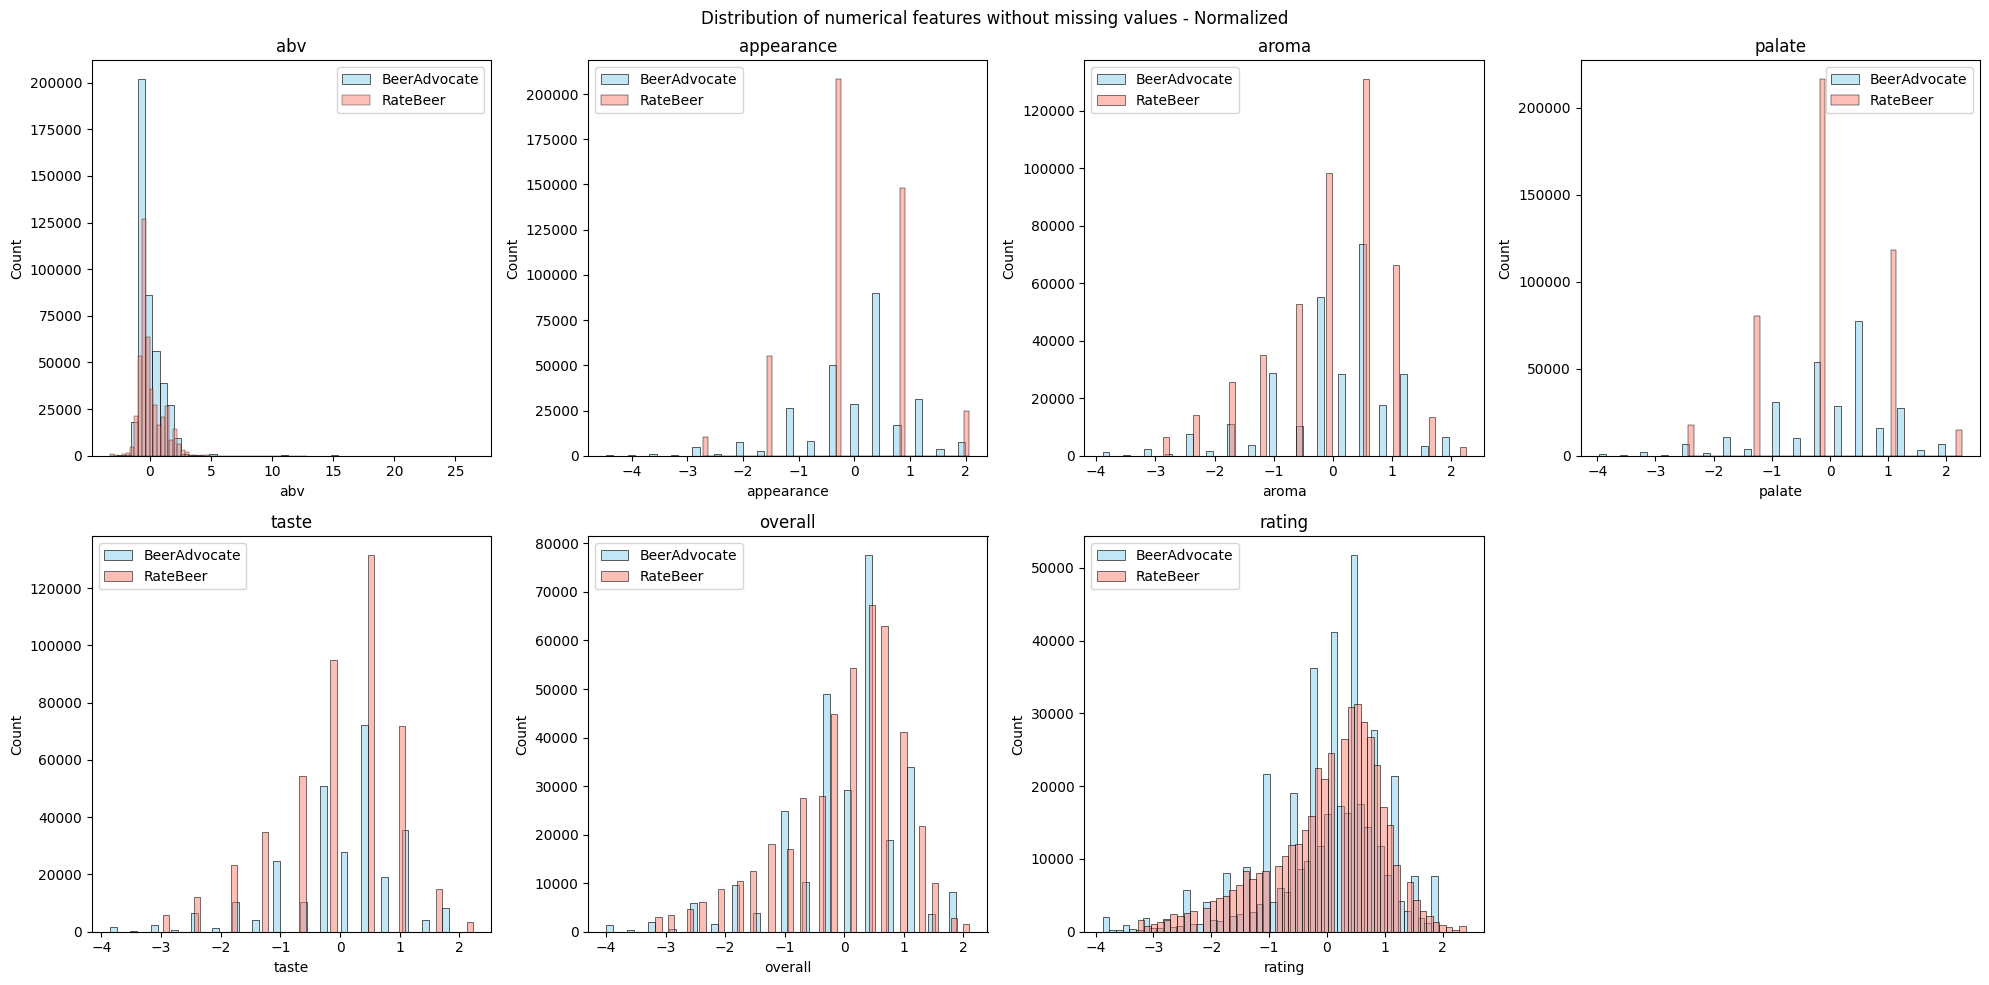

In [45]:
fig = plot_features(normalize_numerical_data(ratings_BA), normalize_numerical_data(ratings_RB), "Distribution of numerical features without missing values - Normalized")


- **date** feature

In [46]:
#Convert date feature
pd.to_numeric(ratings_BA['date'], errors='coerce', downcast='integer')#.astype(int)
ratings_BA_d = ratings_BA.copy()
ratings_BA_d.date = ratings_BA.date.apply(lambda d: pd.to_datetime(d, unit='s'))
ratings_BA_d['date'] = ratings_BA_d['date'].dt.date
ratings_BA_d.head(2)

C:\Users\julie\AppData\Local\Temp\ipykernel_15892\178876661.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  ratings_BA_d.date = ratings_BA.date.apply(lambda d: pd.to_datetime(d, unit='s'))


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
43736,"Hello, My Name Is Ingrid",67199.0,BrewDog,16315.0,American Double / Imperial IPA,8.2,2013-06-05,aztraz,aztraz.671249,NaN,NaN,NaN,NaN,NaN,3.5,nan,False
273843,Solstice D'été Aux Cerises,73716.0,Brasserie Dieu du Ciel!,1141.0,Berliner Weissbier,6.5,2015-10-12,hopsolutely,hopsolutely.513175,4.0,4.0,3.5,4.0,3.75,3.9,Enjoying with thanks to Phyl21ca.Rarely does a...,True


In [47]:
# add evolution en fct du temps des numerical features averaged par website

- **text** feature
    - Cleaning the sentences
        - remove punctuation
        - lemmatization
        - remove stopwords
        - keep only sentences in english

In [48]:
import pandas as pd
import nltk
nltk.download('words')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
#import fasttext

nltk.download('stopwords') # Download NLTK stopwords
nltk.download('wordnet')   # Lemmatization
nltk.download('words')
english_words=set(words.words())
# Get the set of English stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [51]:
def preprocess_sentences(df):    
    # Remove rows with no sentences (NaN values)
    df = df[~df['text'].isnull()]

    # Remove punctuation and convert to lowercase
    def clean_text(sentence):
        translator = str.maketrans('', '', string.punctuation)
        cleaned = sentence.translate(translator).lower()
        return cleaned

    # Function to lemmatize 
    def lemmatize_text(sentence):
        tokens = word_tokenize(sentence)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)

    # Function to remove stop words
    def remove_stopwords(sentence):
        tokens = word_tokenize(sentence)
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
        return ' '.join(filtered_tokens)

    # Function to remove non-english words
    def keep_only_english(sentence):
        return " ".join(w for w in nltk.wordpunct_tokenize(sentence) if w.lower() in english_words or not w.isalpha())

    
    df['cleaned_text'] = df['text'].apply(clean_text)
    df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)
    df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
    df['cleaned_text'] = df['cleaned_text'].apply(keep_only_english)
    df = df.dropna(subset=['cleaned_text']).loc[lambda x:x['cleaned_text'].str.strip() != '']

    return df

def compute_top_words(df):
    # Split the sentences into individual words
    all_words = ' '.join(df['cleaned_text']).split()

    # Count word occurrences
    word_counts = Counter(all_words)

    # Get the top 20 most common words
    top_words = word_counts.most_common(20)

    # Convert to DataFrame for easy plotting
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
    
    return top_words_df

In [53]:
import warnings
warnings.filterwarnings('ignore') # remove the warnings

ratings_BA_cleaned = preprocess_sentences(ratings_BA[:100000]) # select some part of the df because sentences cleaning can be long
ratings_RB_cleaned = preprocess_sentences(ratings_RB[:100000])

warnings.filterwarnings('default')

print(f"Length of dataframe before cleaning: {len(ratings_BA[:100000])}")
print(f"Length of dataframe after cleaning: {len(ratings_BA_cleaned)}")


Length of dataframe before cleaning: 100000
Length of dataframe after cleaning: 99984


In [54]:
# Before preprocessing of the sentences
print("Before cleaning")
mean_words_BA = np.mean(ratings_BA["text"].apply(lambda row : len(str(row))))
mean_words_RB = np.mean(ratings_RB["text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BA : {mean_words_BA}")
print(f"Average number of words in textual reviews of RB : {mean_words_RB}")

NaN_sentences_BA = len(ratings_BA[ratings_BA["text"].isnull()])
NaN_sentences_RB = len(ratings_RB[ratings_RB["text"].isnull()])
print(f"\nNumber of sentences with NaN/0 words in BA :{NaN_sentences_BA}")
print(f"Number of sentences with NaN/0 words in RB :{NaN_sentences_RB}")

# After preprocessing of the sentences
print("\nAfter cleaning")
mean_words_BA = np.mean(ratings_BA_cleaned["cleaned_text"].apply(lambda row : len(str(row))))
mean_words_RB = np.mean(ratings_RB_cleaned["cleaned_text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BA : {mean_words_BA}")
print(f"Average number of words in textual reviews of RB : {mean_words_RB}")

NaN_sentences_BA = len(ratings_BA_cleaned[ratings_BA_cleaned["cleaned_text"].isnull()])
NaN_sentences_RB = len(ratings_RB_cleaned[ratings_RB_cleaned["cleaned_text"].isnull()])
print(f"\nNumber of sentences with NaN/0 words in BA :{NaN_sentences_BA}")
print(f"Number of sentences with NaN/0 words in RB :{NaN_sentences_RB}")

Before cleaning
Average number of words in textual reviews of BA : 290.318211995796
Average number of words in textual reviews of RB : 308.98221555747045

Number of sentences with NaN/0 words in BA :2
Number of sentences with NaN/0 words in RB :2

After cleaning
Average number of words in textual reviews of BA : 164.19506120979358
Average number of words in textual reviews of RB : 182.63514339233305

Number of sentences with NaN/0 words in BA :0
Number of sentences with NaN/0 words in RB :0


Top N most common words after preprocessing

In [55]:
N = 20

# BeerAdvocate
common_unigrams_BA = get_top_n_i_gram(ratings_BA_cleaned['cleaned_text'], 1, N)
common_bigrams_BA = get_top_n_i_gram(ratings_BA_cleaned['cleaned_text'], 2, N)
common_trigrams_BA = get_top_n_i_gram(ratings_BA_cleaned['cleaned_text'], 3, N)
# Rate Beer
common_unigrams_RB = get_top_n_i_gram(ratings_RB_cleaned['cleaned_text'], 1, N)
common_bigrams_RB = get_top_n_i_gram(ratings_RB_cleaned['cleaned_text'], 2, N)
common_trigrams_RB = get_top_n_i_gram(ratings_RB_cleaned['cleaned_text'], 3, N)

In [57]:
def plot_ngrams(common_unigrams, common_bigrams, common_trigrams):
    # Creating subplots
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    # Subplot 1: Common Unigrams
    df1 = pd.DataFrame(common_unigrams, columns=['Review Text', 'count'])
    df1.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[0])
    axes[0].set_title(f'Top {N} words in reviews')

    # Subplot 2: Common Bigrams
    df2 = pd.DataFrame(common_bigrams, columns=['Review Text', 'count'])
    df2.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[1])
    axes[1].set_title(f'Top {N} bigrams in reviews')

    # Subplot 3: Common Trigrams
    df3 = pd.DataFrame(common_trigrams, columns=['Review Text', 'count'])
    df3.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[2])
    axes[2].set_title(f'Top {N} trigrams in reviews')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

##### BeerAdvocate

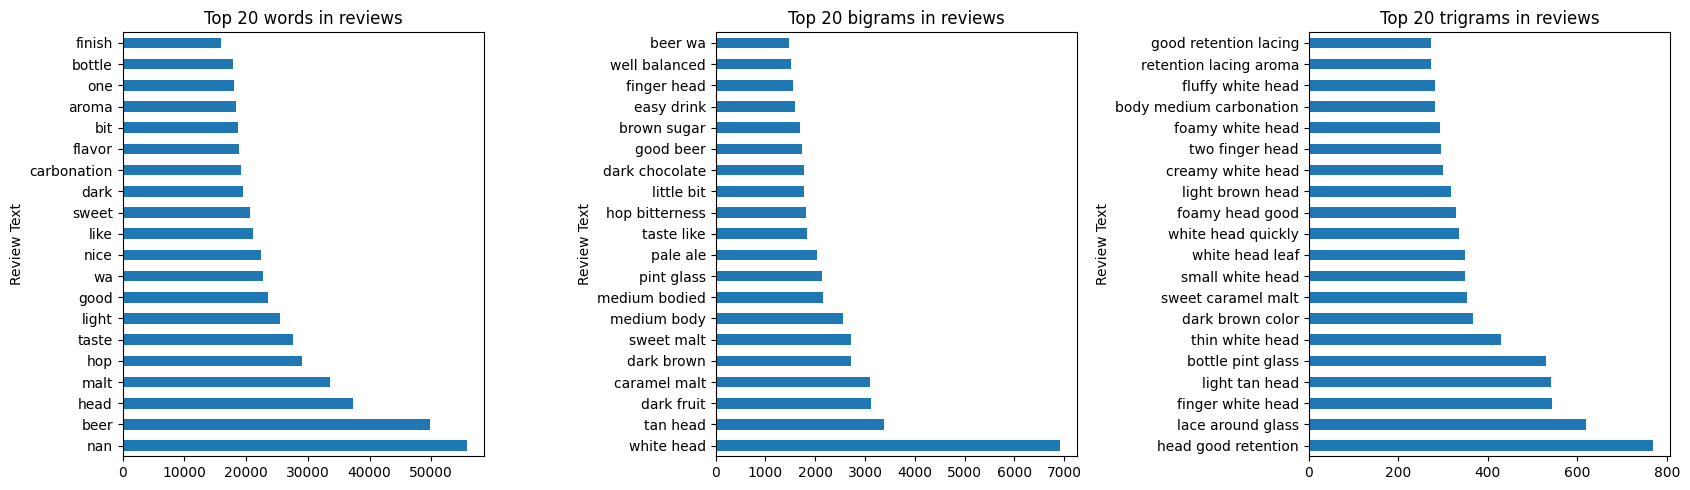

##### RateBeer

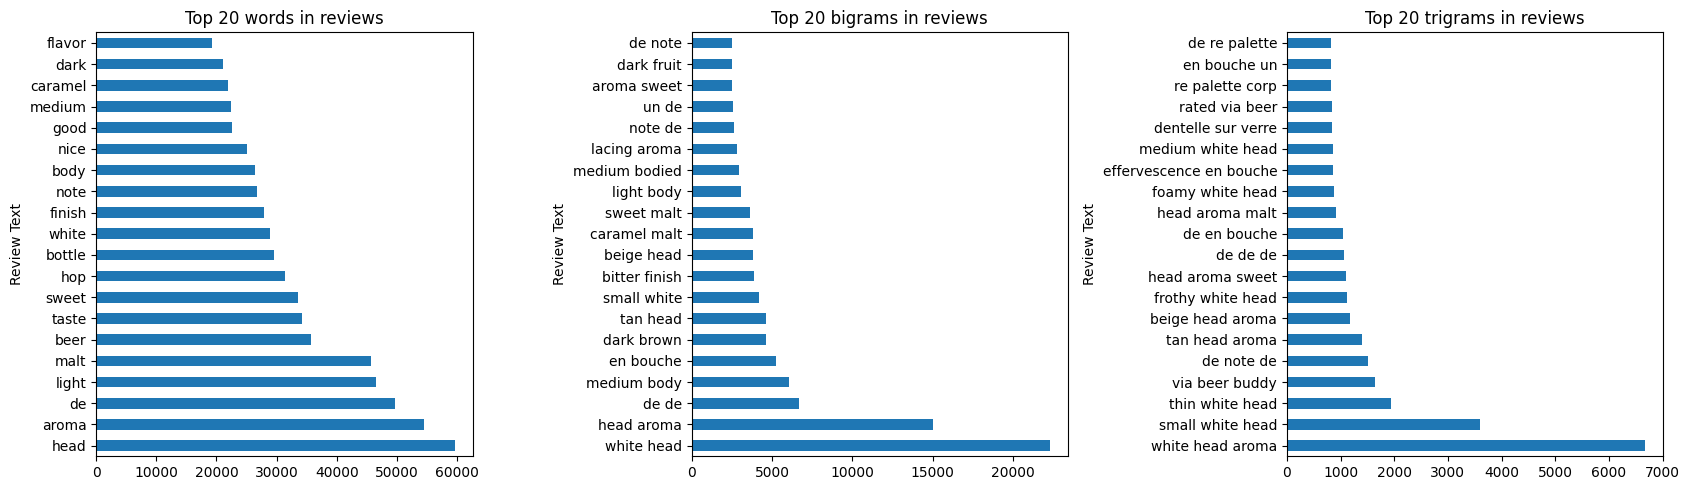

In [58]:
display(Markdown("##### BeerAdvocate"))
plot_ngrams(common_unigrams_BA, common_bigrams_BA, common_trigrams_BA)
display(Markdown("##### RateBeer"))
plot_ngrams(common_unigrams_RB, common_bigrams_RB, common_trigrams_RB)

---

## Feasibility check of project's methods
- give their essential mathematical details in the notebook.


1. Ratings distribution
2. Sentiment analysis
3. Check extreme users

### 1. Ratings distribution

add an explanation of why it is relevant for our story

In [59]:
# todo

- ratings in function of the time

To asses whether the yearly evolution of the tastes changes, the following plot shows the evolution of the average rating per month along the years

In [60]:
def transform_date(df):
    """
    Transforms the 'date' column of the input DataFrame to a datetime object and extracts the date.
    
    Parameters
    ----------
    df : DataFrame
        The input DataFrame to be transformed.

    Returns
    -------
    df : DataFrame
        The transformed DataFrame.
                
    """
    df_d = df.copy()
    df_d['date'] = pd.to_datetime(df_d['date'], unit='s').dt.date
    return df_d

def create_month_feature(df):
    """
    Creates a new feature 'month' from the 'date' column of the input DataFrame.
    
    Parameters
    ----------
    df : DataFrame
        The input DataFrame to be transformed.

    Returns
    -------
    df : DataFrame
        The transformed DataFrame.
                
    """
    df_m = df.copy()
    df_m['month'] = pd.to_datetime(df_m['date']).dt.month
    return df_m

def plot_rating_versus_month(df1, df2):
    """
    Plots the average rating per month for two dataframes.
    
    Parameters
    ----------
    df1 : DataFrame
        The first input DataFrame to be transformed.
    df2 : DataFrame
        The second input DataFrame to be transformed.

    Returns
    -------
    None
                
    """
    df1_d = transform_date(df1)
    df2_d = transform_date(df2)
    df1_m = create_month_feature(df1_d)
    df2_m = create_month_feature(df2_d)
    df1_m = df1_m.groupby('month')['rating'].agg('mean')
    df2_m = df2_m.groupby('month')['rating'].agg('mean')
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df1_m.index, df1_m.values, label='DataFrame 1')
    ax.plot(df2_m.index, df2_m.values, label='DataFrame 2')
    ax.set_xlabel('Month')
    ax.set_ylabel('Average rating')
    ax.set_title('Average rating per month')
    ax.legend()
    plt.show()


C:\Users\julie\AppData\Local\Temp\ipykernel_15892\126567905.py:17: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_d['date'] = pd.to_datetime(df_d['date'], unit='s').dt.date
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\126567905.py:17: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_d['date'] = pd.to_datetime(df_d['date'], unit='s').dt.date


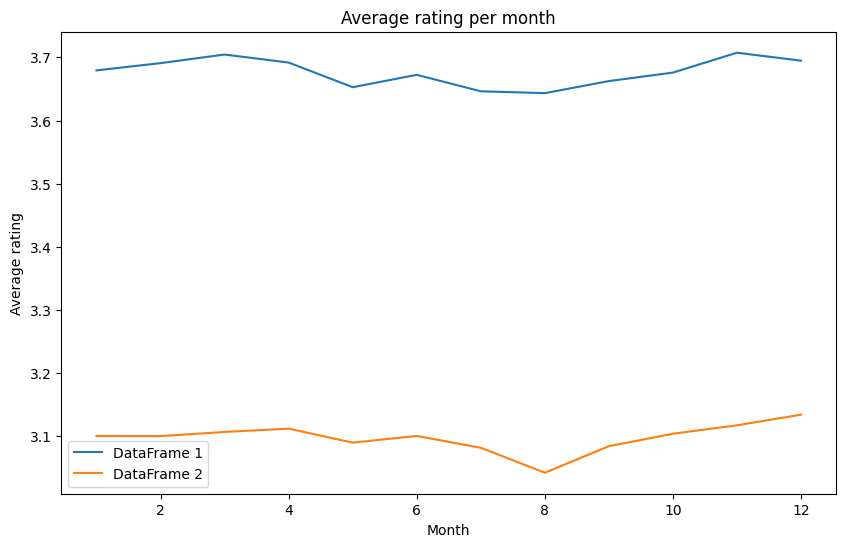

In [61]:
plot_rating_versus_month(ratings_BA, ratings_RB)

In [62]:
def plot_most_consumed_beer_style_per_month(df):
    """
    Plots the most consumed beer style per month.
    
    Parameters
    ----------
    df : DataFrame
        The input DataFrame to be used for plotting.

    Returns
    -------
    None
                
    """
    # group the data by month and beer style
    dated_df = transform_date(df)
    monthed_df = create_month_feature(dated_df)
    df_month_style = monthed_df.groupby(['month', 'style']).size().reset_index(name='count')

    # get the most consumed beer style per month
    idx = df_month_style.groupby(['month'])['count'].transform(max) == df_month_style['count']
    df_most_consumed = df_month_style[idx]

    # plot the most consumed beer style per month
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 5))
    sns.barplot(x="month", y="count", hue="style", data=df_most_consumed)
    plt.title("Most consumed beer style per month")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.show()


C:\Users\julie\AppData\Local\Temp\ipykernel_15892\126567905.py:17: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_d['date'] = pd.to_datetime(df_d['date'], unit='s').dt.date
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1549327602.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = df_month_style.groupby(['month'])['count'].transform(max) == df_month_style['count']


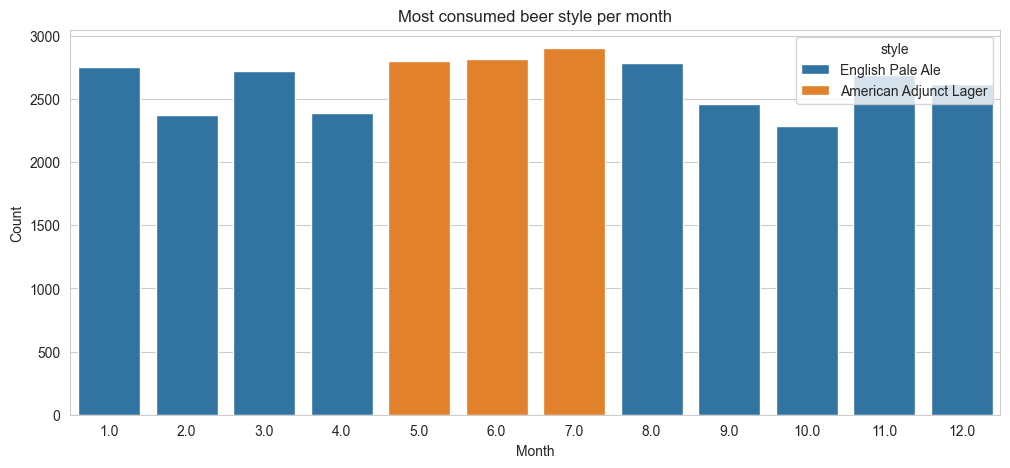

C:\Users\julie\AppData\Local\Temp\ipykernel_15892\126567905.py:17: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_d['date'] = pd.to_datetime(df_d['date'], unit='s').dt.date
C:\Users\julie\AppData\Local\Temp\ipykernel_15892\1549327602.py:21: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = df_month_style.groupby(['month'])['count'].transform(max) == df_month_style['count']


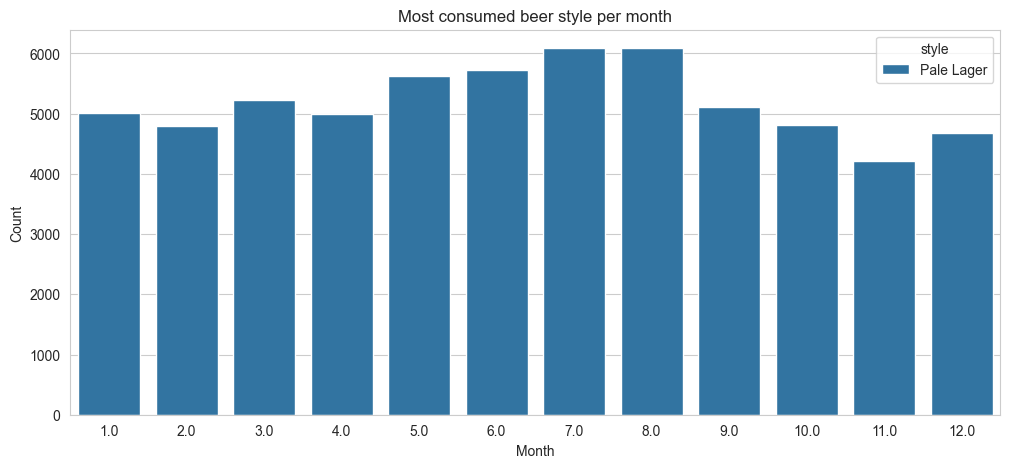

In [63]:
plot_most_consumed_beer_style_per_month(ratings_BA)
plot_most_consumed_beer_style_per_month(ratings_RB)

### Sentiment analysis

In [64]:
from textblob import TextBlob
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

**Polarity - subjectivity per website**

BeerAdvocate

### Need to fix subjectivity of BA

In [65]:
warnings.filterwarnings('ignore') # remove the warnings

# with original text
ratings_BA_cleaned['polarity_text'] = ratings_BA_cleaned['text'].apply(lambda x: getPolarity(x))
ratings_BA_cleaned['subjectivity_text'] = ratings_BA_cleaned['text'].apply(lambda x: getSubjectivity(x))
ratings_BA_cleaned['polarity_Analysis'] = ratings_BA_cleaned['polarity_text'].apply(lambda x: getAnalysis(x))
# with cleaned text
ratings_BA_cleaned['polarity_cleaned_text'] = ratings_BA_cleaned['cleaned_text'].apply(lambda x: getPolarity(x))
ratings_BA_cleaned['subjectivity_cleaned_text'] = ratings_BA_cleaned['cleaned_text'].apply(lambda x: getSubjectivity(x))
ratings_BA_cleaned['cleaned_polarity_Analysis'] = ratings_BA_cleaned['polarity_text'].apply(lambda x: getAnalysis(x))



RateBeer

In [67]:
# with original text
ratings_RB_cleaned['polarity_text'] = ratings_RB_cleaned['text'].apply(lambda x: getPolarity(x))
ratings_RB_cleaned['subjectivity_text'] = ratings_RB_cleaned['text'].apply(lambda x: getSubjectivity(x))
ratings_RB_cleaned['polarity_Analysis'] = ratings_RB_cleaned['polarity_text'].apply(lambda x: getAnalysis(x))
# with cleaned text
ratings_RB_cleaned['polarity_cleaned_text'] = ratings_RB_cleaned['cleaned_text'].apply(lambda x: getPolarity(x))
ratings_RB_cleaned['subjectivity_cleaned_text'] = ratings_RB_cleaned['cleaned_text'].apply(lambda x: getSubjectivity(x))
ratings_RB_cleaned['cleaned_polarity_Analysis'] = ratings_RB_cleaned['polarity_text'].apply(lambda x: getAnalysis(x))

In [68]:
ratings_RB_cleaned.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,overall,rating,text,cleaned_text,polarity_text,subjectivity_text,polarity_Analysis,polarity_cleaned_text,subjectivity_cleaned_text,cleaned_polarity_Analysis
262500,Brew Brothers Prairie Berry Ale,21927.0,Brew Brothers Brewing &#40;Alberta&#41;,3033.0,Fruit Beer,5.5,1044615600,presario,5348,3.0,...,13.0,3.2,Big blue 1L bottle. Very loud pop announced t...,big blue 1l bottle loud pop office wa beer tim...,0.130923,0.577381,Positive,0.119940,0.552381,Positive
39881,Ed Hardy Premium Beer,110849.0,Cervecería Mexicana (Grupo Modelo),5973.0,Pale Lager,4.6,1281520800,Cajun,47922,2.0,...,5.0,1.6,Tasting - Gulf Brew 2010 - Pale amber white he...,tasting gulf brew 2010 pale amber white head n...,-0.042000,0.176000,Negative,-0.052500,0.220000,Negative
326014,Barnstormer Billy Bishop Brown,234971.0,Barnstormer Brewing,17952.0,Brown Ale,3.8,1447498800,crazy_cat_lady,252434,3.0,...,15.0,3.2,Can in Brew Box. Very dark brown with tan head...,brew box dark brown tan head bitter chocolate ...,-0.022333,0.557333,Negative,-0.223333,0.533333,Negative
138035,Dieu du Ciel Route des Épices,15138.0,Dieu du Ciel,364.0,Spice/Herb/Vegetable,5.0,1190541600,MartinT,4919,4.0,...,15.0,3.7,My Bottom Line:This wondrous Black Pepper Rye ...,bottom wondrous black pepper rye ale healthy r...,0.231667,0.495000,Positive,0.221667,0.495000,Positive
131056,Dieu du Ciel Péché Mortel,11461.0,Dieu du Ciel,364.0,Imperial Stout,9.5,1267614000,Frank,5777,4.0,...,15.0,3.6,I recall first trying this at a Dark Lord Day ...,recall first trying dark lord day way four yea...,0.179861,0.611690,Positive,0.202257,0.567593,Positive


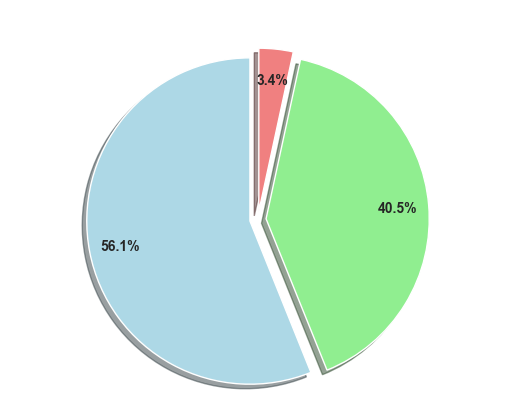

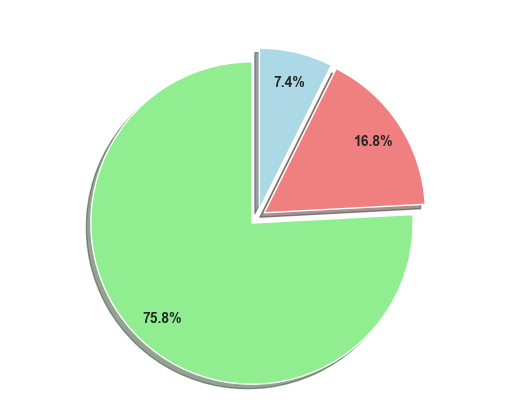

In [93]:
def plot_pie_chart(df):
    polarity_counts = df['polarity_Analysis'].value_counts()

    labels = polarity_counts.index
    sizes = polarity_counts.values
    myexplode=[0.05, 0.05, 0.05]
    category_color = {'Positive': 'lightgreen', 'Neutral': 'lightblue', 'Negative': 'lightcoral'}
    
    colors = [category_color[label] for label in labels]
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, explode=myexplode, colors= colors, autopct='%1.1f%%', startangle=90, pctdistance=0.81, shadow=True)

    fig.patch.set_facecolor('none')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Customize the appearance of labels and autopct values
    plt.setp(texts, fontsize=12, fontweight='bold', color= 'white')
    plt.setp(autotexts, fontsize=10, fontweight='bold')
    plt.title('Distribution of Polarity', fontsize=14, fontweight='bold', color='white')
    plt.show()



plot_pie_chart(ratings_BA_cleaned)
plot_pie_chart(ratings_RB_cleaned)

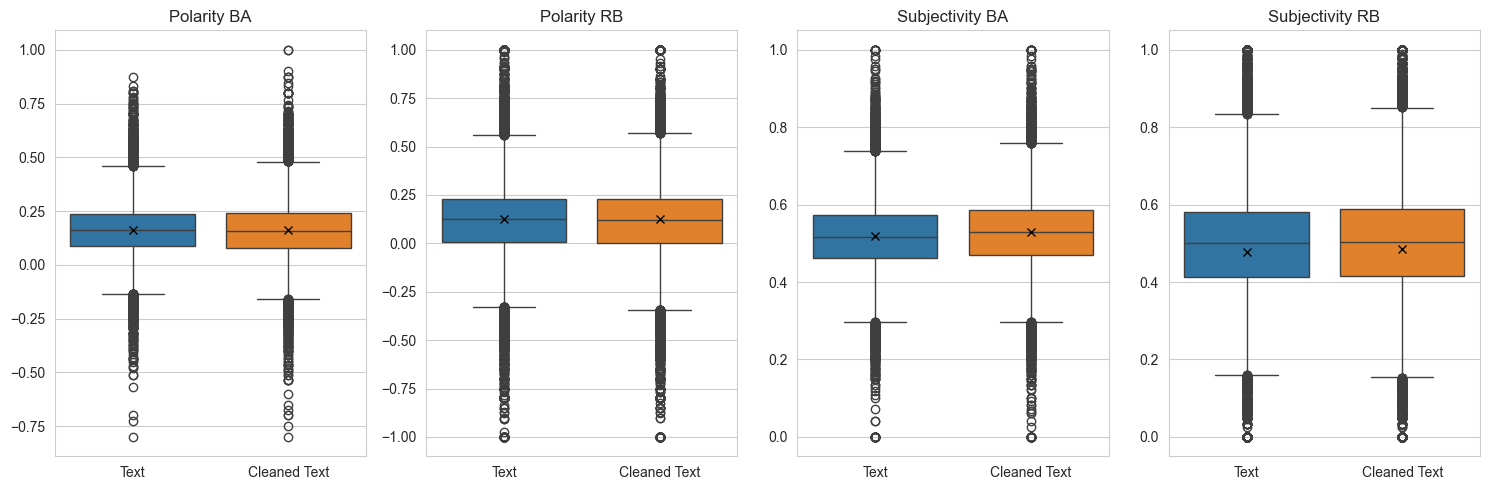

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(15, 5))
sns.boxplot(data = ratings_BA_cleaned[['polarity_text', 'polarity_cleaned_text']], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[0])
sns.boxplot(data = ratings_RB_cleaned[['polarity_text', 'polarity_cleaned_text']], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[1])

sns.boxplot(data = ratings_BA_cleaned[['subjectivity_text', 'subjectivity_cleaned_text']], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[2])
sns.boxplot(data = ratings_RB_cleaned[['subjectivity_text', 'subjectivity_cleaned_text']], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[3])

for i in range(4):
    axs[i].set_xticklabels(['Text', 'Cleaned Text'])

axs[0].set_title(f"Polarity BA")
axs[1].set_title(f"Polarity RB")
axs[2].set_title(f"Subjectivity BA")
axs[3].set_title(f"Subjectivity RB")
plt.tight_layout()
plt.show()

**Polarity - subjectivity per brewery**

In [ ]:
def plot_polarity_subjectivity_per_topk_brewery(website):
    if website == 'BeerAdvocate': 
        df = ratings_BA_cleaned
    else:
        df = ratings_RB_cleaned
    k_breweries = 0.9995
    ratings_topk_breweries = filter_topk_breweries(df, k_breweries)

    fig, axs = plt.subplots(1,2, figsize=(15, 6), sharey = True)
    sns.boxplot(data = ratings_topk_breweries, x = 'polarity_text', y = 'style', showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[0])
    sns.boxplot(data = ratings_topk_breweries, x = 'subjectivity_text', y = 'style', showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[1])

    axs[0].set_title(f"Polarity top {np.round(100*(1-k_breweries),3)} % breweries")
    axs[1].set_title(f"Subjectivity top {np.round(100*(1-k_breweries),3)} % breweries")

    plt.tight_layout()
    plt.show()

##### Beer Advocate

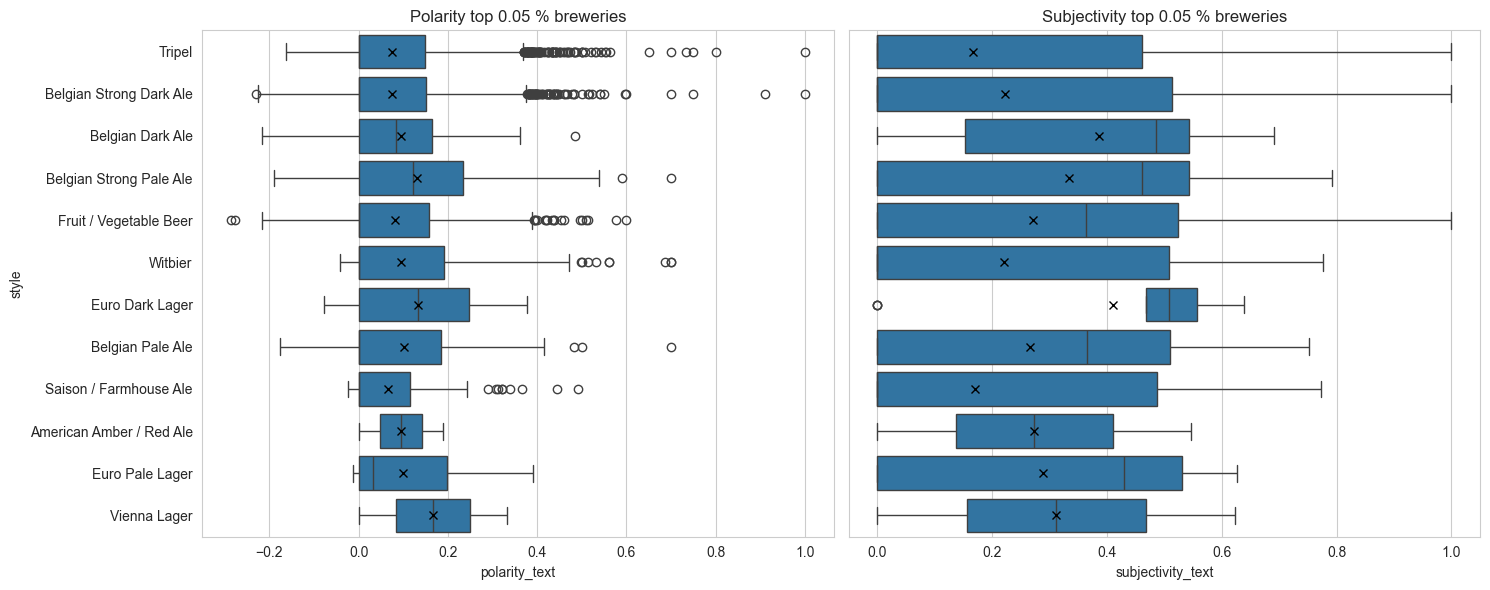

##### RateBeers

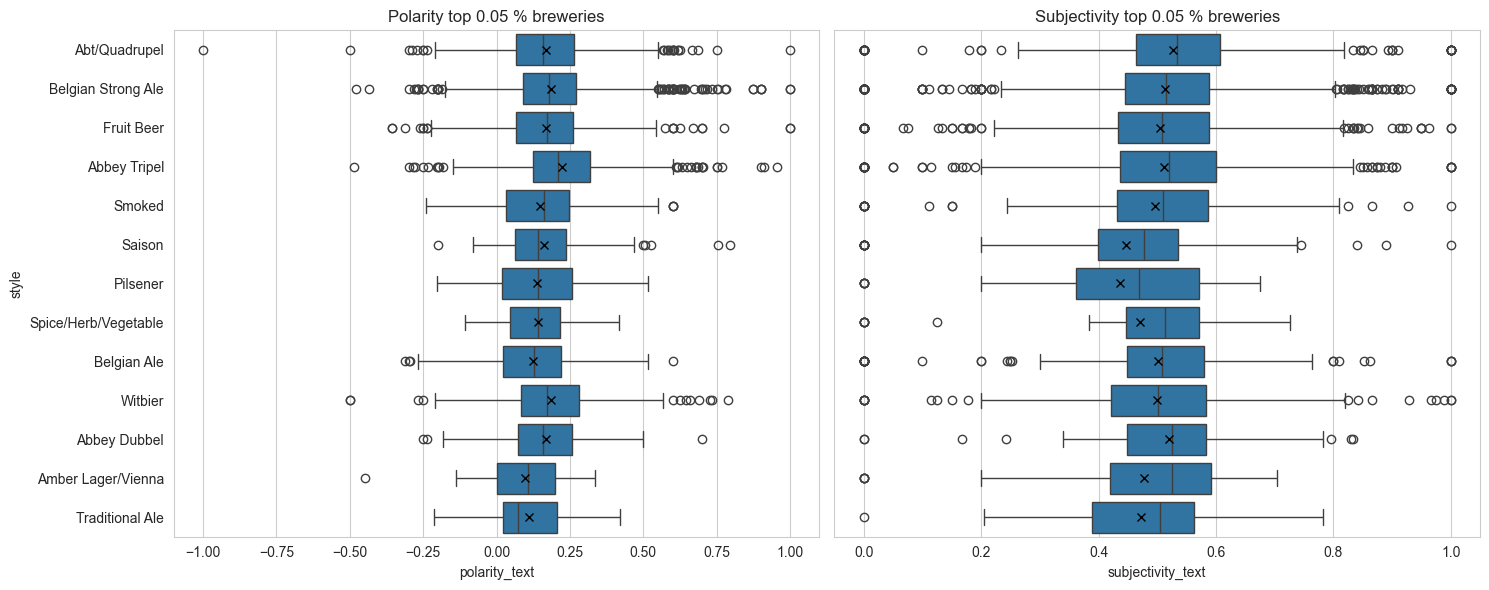

In [ ]:
display(Markdown("##### Beer Advocate"))
plot_polarity_subjectivity_per_topk_brewery(website = 'BeerAdvocate')
display(Markdown("##### RateBeers"))
plot_polarity_subjectivity_per_topk_brewery(website = 'RateBeer')

**Polarity - subjectivity per style**

In [ ]:
def plot_polarity_subjectivity_per_topk_style(website):
    if website == 'BeerAdvocate': 
        df = ratings_BA_cleaned
    else:
        df = ratings_RB_cleaned
    k_styles = 0.9
    ratings_topk_styles = filter_topk_styles(df, k_styles)

    fig, axs = plt.subplots(1,2, figsize=(15, 4), sharey = True)
    sns.boxplot(data = ratings_topk_styles, x = 'polarity_text', y = 'style', showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[0])
    sns.boxplot(data = ratings_topk_styles, x = 'subjectivity_text', y = 'style', showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[1])

    axs[0].set_title(f"Polarity top {np.round(100*(1-k_styles),0)} % styles")
    axs[1].set_title(f"Subjectivity top {np.round(100*(1-k_styles),0)} % styles")

    plt.tight_layout()
    plt.show()

##### BeerAdvocate

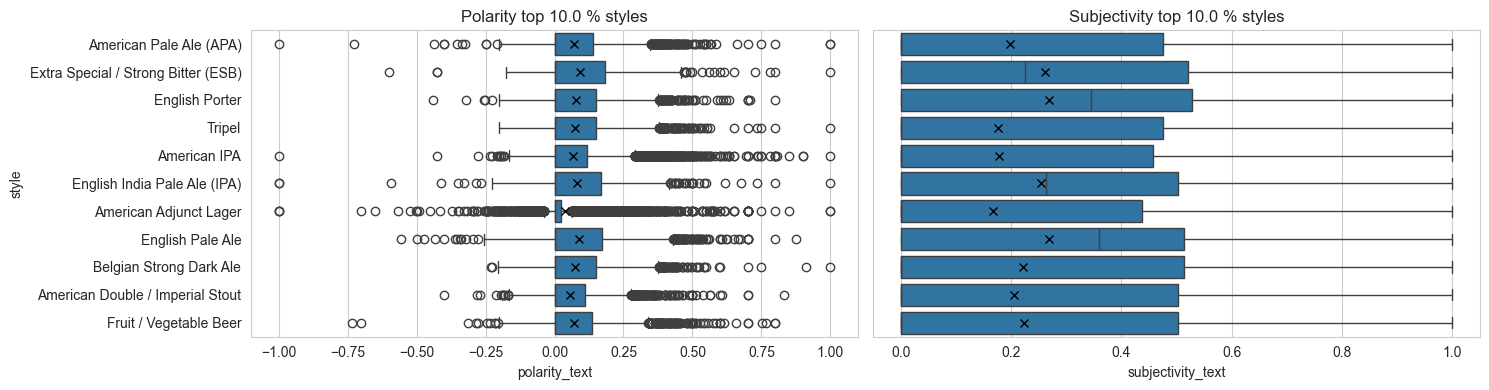

##### RateBeers

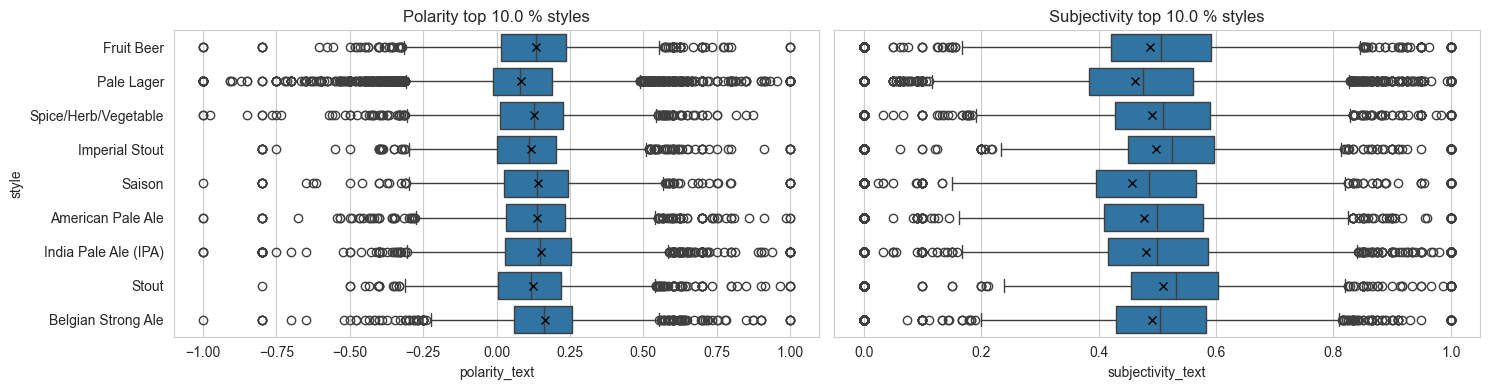

In [ ]:
display(Markdown("##### BeerAdvocate"))
plot_polarity_subjectivity_per_topk_style(website = 'BeerAdvocate')
display(Markdown("##### RateBeers"))
plot_polarity_subjectivity_per_topk_style(website = 'RateBeer')

## Alternatives considered
- analysis and communication is reasonable

In [ ]:
# todo